In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from src.utils.plot import plot_normalized_positions
from src.utils.paths import paths_no_backtrack, get_pairs_with_defined_distance
from src.utils.probs import posterior_probabilites, entropies_prior_posterior, information_gain
from src.utils.distances import compute_distances
from src.utils.load_data import load_data
from src.scripts.generate_embeddings_distances import get_embeddings_distances

/home/t/.conda/envs/ada_proj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data loading and pre-processing

In [2]:
articles, categories, links, paths_finished_humans, paths_finished_llm_no_memory, paths_finished_llm_memory, paths_unfinished_humans, paths_unfinished_llm_no_memory, paths_unfinished_llm_memory = load_data()

### Handling Missing Values

We found missing values for the rating of finished paths and decided not to impute them as replacing missing values with the median rating would not make sense. We will only use finished paths with a human rating and discard all other finished paths when we need to make analysis based on the rating.

### Handling the data size

Our pipeline can handle the datasize as we do not need to handle bigger datasets than the ones we have already treated through this pipeline.

### Analyzing path lengths

We see that the LLM has a low median and mean path length, **but** the here we only consider the LLM paths that finished, and about 50% of the LLM paths failed, so this does not mean much yet.

TODO Analyze again once we have the paths of LLM with memory

In [3]:
# Compute descriptive statistics human and LLM finished paths lengths
paths_finished_humans['path_length'] = paths_finished_humans['path'].apply(len)
print(paths_finished_humans['path_length'].describe())
print(paths_finished_llm_no_memory.apply(len).describe())

count    51307.000000
mean         6.758668
std          4.680461
min          2.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        435.000000
Name: path_length, dtype: float64
count    14527.000000
mean         4.661527
std          1.612817
min          2.000000
25%          4.000000
50%          4.000000
75%          6.000000
max         17.000000
Name: path, dtype: float64


In [4]:
# Analyze the ratings given by humans
paths_finished_humans['rating'].describe()

count    28501.000000
mean         2.269780
std          1.110439
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rating, dtype: float64

### Exploring correlations

Here we evaluate the correlation between the difficulty and the path length for human games. 
We observe that the rating is positively correlated with the path length.
R2 shows that our model explains some of the variance of the data.
p is close to 0 which shows that the rating is a good predictor for the path length.

In [5]:
mod = smf.ols(formula='path_length ~ rating', data=paths_finished_humans)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            path_length   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     5551.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:48:23   Log-Likelihood:                -84559.
No. Observations:               28501   AIC:                         1.691e+05
Df Residuals:                   28499   BIC:                         1.691e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4686      0.063     38.950      0.000       2.344       2.593
rating         1.8687      0.025     74.502      0.000       1.819       1.918
==============================================================================
Omnibus:                    73824.614   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       6510845304.372
Skew:                          29.186   Prob(JB):                         0.00
Kurtosis:                    2343.773   Cond. No.                         6.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2. Compute probabilities and entropies

### 2.A. Prior click probability

![Formula for the prior click probability](./images/probs_prior.png)

The prior click probability only depends on the number of outlinks of each article.

In [6]:
# Count the out-links of each article to get the probability of clicking on any of them
out_degree = links.groupby('linkSource').size()
probs_prior = 1 / out_degree
# Create a Series indexed by 'linkSource' that gives a list of all the source’s out-links
out_links = links.groupby('linkSource')['linkTarget'].agg(list)

### 2.B. Posterior click probability

![Formula for the posterior click probability](./images/probs_posterior.png)

In [7]:
paths_finished_humans = paths_no_backtrack(paths_finished_humans['path'])
probs_posterior_humans = posterior_probabilites(paths_finished_humans, out_links, out_degree)
probs_posterior_llm_no_memory = posterior_probabilites(paths_finished_llm_no_memory, out_links, out_degree)
probs_posterior_llm_memory = posterior_probabilites(paths_finished_llm_memory, out_links, out_degree)

### 2.C. Prior and posterior entropies

Compute the prior and posterior entropy at each article along the path, except for the goal, because entropy is 0 once we have reached the goal.

In [8]:
entropies_prior_humans, entropies_posterior_humans = entropies_prior_posterior(paths_finished_humans, probs_prior, probs_posterior_humans, out_degree)
entropies_prior_llm_no_memory, entropies_posterior_llm_no_memory = entropies_prior_posterior(paths_finished_llm_no_memory, probs_prior, probs_posterior_llm_no_memory, out_degree)
entropies_prior_llm_memory, entropies_posterior_llm_memory = entropies_prior_posterior(paths_finished_llm_memory, probs_prior, probs_posterior_llm_memory, out_degree)

## 3. Split the paths

### 3.A. Compute “information gain”

This represents how much information we gain by looking at the click distribution, as described in section 4 and figure 2 of the paper.

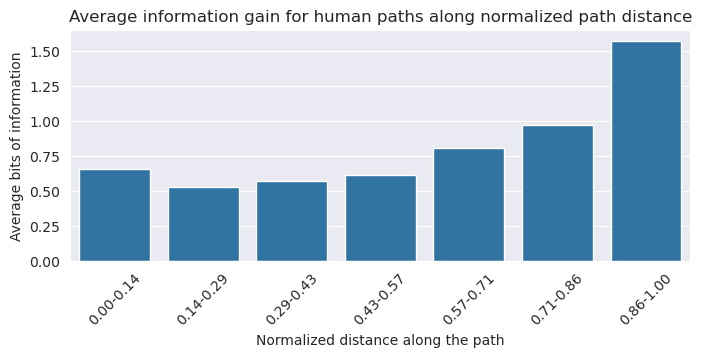

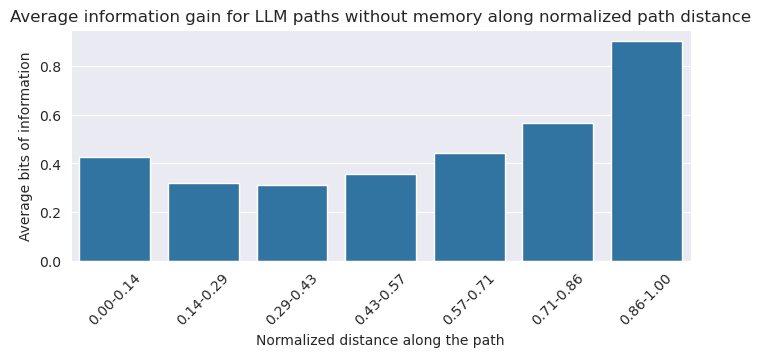

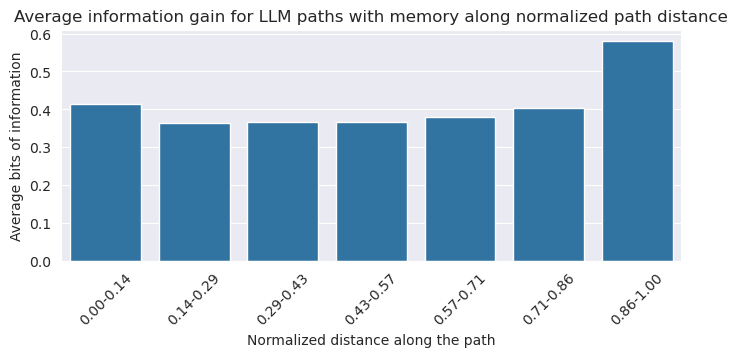

In [9]:
# Compute and plot the information gain for human and for LLM paths
info_gain_humans = information_gain(entropies_prior_humans, entropies_posterior_humans)
info_gain_llm_no_memory = information_gain(entropies_prior_llm_no_memory, entropies_posterior_llm_no_memory)
info_gain_llm_memory = information_gain(entropies_prior_llm_memory, entropies_posterior_llm_memory)
plot_normalized_positions(info_gain_humans, 'information gain for human paths')
plot_normalized_positions(info_gain_llm_no_memory, 'information gain for LLM paths without memory')
plot_normalized_positions(info_gain_llm_memory, 'information gain for LLM paths with memory')

This is similar to what the paper gets:

![information gain graph from the paper](./images/fig_2_paper.png)

We can see that the LLM seems to exhibit the same strategy of “getting away” from the starting article to a more general/generic “hub” article, and then “homing in” on the target article by getting more and more specific.

TODO: we need a statistical test to verify that rigorously. This graph only shows **average** information gain along **normalized** path length.

### 3.B. Get the splitting point and split the paths

In [10]:
# Get the index of the point of lowest information gain for each path
argmin_info_gain_humans = info_gain_humans.apply(np.argmin)
argmin_info_gain_llm_no_memory = info_gain_llm_no_memory.apply(np.argmin)
argmin_info_gain_llm_memory = info_gain_llm_memory.apply(np.argmin)
# Split the path at this point and keep only the second part, corresponding to the “homing in” phase
paths_homing_in_humans = pd.Series([path[argmin_info_gain_humans[i]:] for i, path in paths_finished_humans.items()])
paths_homing_in_llm_no_memory = pd.Series([path[argmin_info_gain_llm_no_memory[i]:] for i, path in paths_finished_llm_no_memory.items()])
paths_homing_in_llm_memory = pd.Series([path[argmin_info_gain_llm_memory[i]:] for i, path in paths_finished_llm_memory.items()])

## 4. Compute embedding distances

We now need to get a list of all the article titles whose embedding we need to compute, as well as the list of pairs of articles between which we need to compute the distance.

In [11]:
# Compute the set of all articles encountered in the paths_homing_in_humans
# Every article encountered along a goal has a defined distance with the goal
all_distance_pairs, all_articles = get_pairs_with_defined_distance(paths_homing_in_humans)

We use the sentence-transformers library to load the pre-trained BERT model and compute embeddings for each of our article titles. Then, we compute distances between these embeddings models, using both cosine similarity and Euclidean distance, which we return in a dataframe `similarities`.

In [12]:
distance_embeddings = get_embeddings_distances(all_articles, all_distance_pairs, 'data/article_similarities.csv')

## 5. Compute semantic distances

In [13]:
distances_humans = pd.Series(compute_distances(links, probs_posterior_humans, paths_homing_in_humans, 'data/distances_humans.pkl'))
distances_llm_no_memory = pd.Series(compute_distances(links, probs_posterior_llm_no_memory, paths_finished_llm_no_memory, 'data/distances_llm_no_memory.pkl'))
distances_llm_memory = pd.Series(compute_distances(links, probs_posterior_llm_memory, paths_finished_llm_memory, 'data/distances_llm_memory.pkl'))

In [14]:
intersection_index = distances_humans.index.intersection(distances_llm_no_memory.index)
semantic_distances = pd.DataFrame({ 'humans': distances_humans, 'llm_no_memory': distances_llm_no_memory, 'llm_memory': distances_llm_memory}, index=intersection_index)

In [15]:
semantic_distances.describe()

,humans,llm_no_memory,llm_memory
count,15866.000000,15866.000000,5470.000000
mean,0.384870,0.403347,0.372536
std,0.472799,0.268385,0.326953
min,0.000844,0.006247,0.006203
25%,0.176986,0.211733,0.177001
50%,0.316225,0.350472,0.288108
75%,0.498339,0.529106,0.470229
max,37.811398,3.494916,5.068087


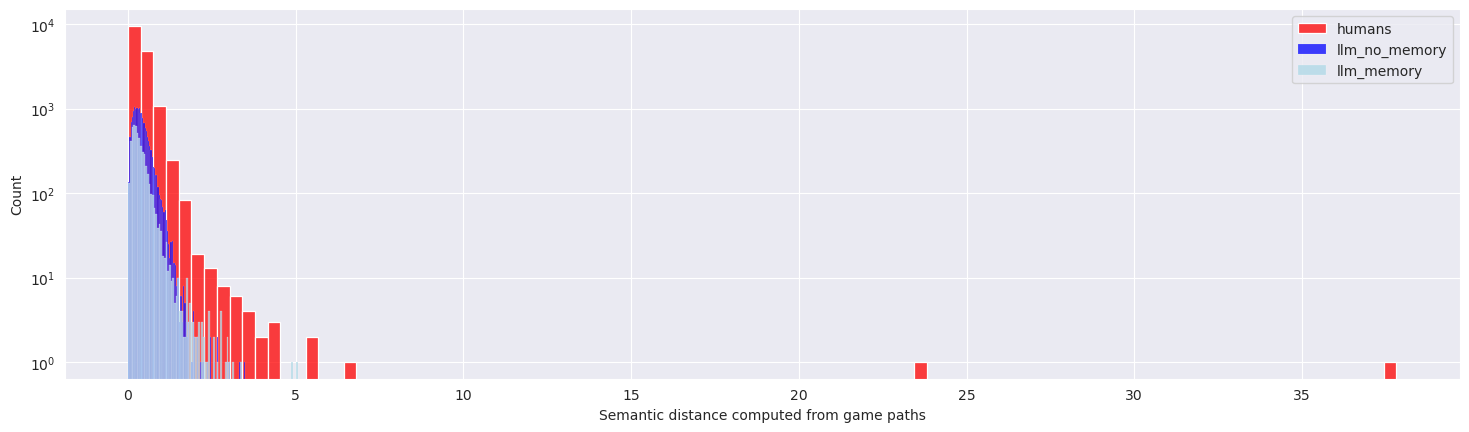

In [16]:
plt.figure().set_figwidth(18)
sns.histplot(semantic_distances['humans'][intersection_index], bins=100, color='red', label='humans')
sns.histplot(semantic_distances['llm_no_memory'][intersection_index], bins=100, color='blue', label='llm_no_memory')
sns.histplot(semantic_distances['llm_memory'][intersection_index], bins=100, color='lightblue', label='llm_memory')
plt.legend()
plt.xlabel('Semantic distance computed from game paths')
plt.yscale('log')

In [17]:
distance_differences_humans_llm_no_memory = pd.Series(distances_humans - distances_llm_no_memory, index=intersection_index)

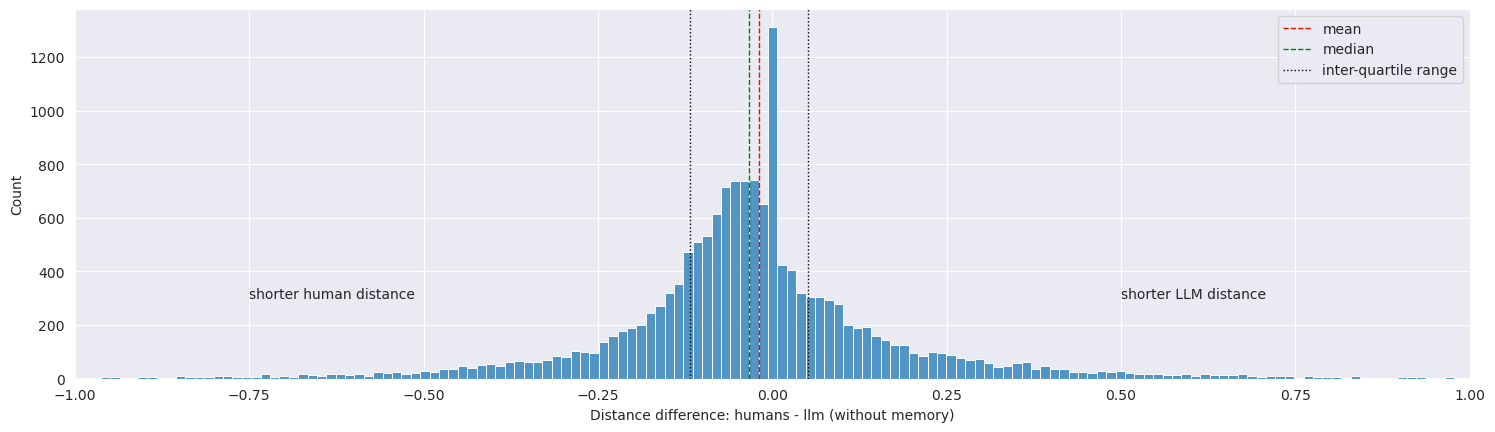

In [18]:
plt.figure().set_figwidth(18)
plt.xlim(-1,1)
sns.histplot(distance_differences_humans_llm_no_memory)
plt.xlabel('Distance difference: humans - llm (without memory)')
plt.text(x=-0.75, y=300, s='shorter human distance')
plt.text(x=0.5, y=300, s='shorter LLM distance')
# make the mean, median visible
plt.axvline(distance_differences_humans_llm_no_memory.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(distance_differences_humans_llm_no_memory.median(), color='green', linestyle='dashed', linewidth=1)
# show the 25th and 75th percentile
plt.axvline(distance_differences_humans_llm_no_memory.quantile(0.25), color='black', linestyle='dotted', linewidth=1)
plt.axvline(distance_differences_humans_llm_no_memory.quantile(0.75), color='black', linestyle='dotted', linewidth=1)
plt.legend(['mean', 'median', 'inter-quartile range'])

In [19]:
distance_differences_humans_llm_no_memory.describe()

count    15866.000000
mean        -0.018477
std          0.450774
min         -3.091321
25%         -0.117988
50%         -0.033702
75%          0.051277
max         37.486572
dtype: float64

In [20]:
# Print the 10 pairs with the highest difference
distance_differences_humans_llm_no_memory.nsmallest(10)

6th_century  20th_century      -3.091321
             Rainforest        -3.091321
             19th_century      -2.781373
1st_century  16th_century      -2.751327
Radio        Ship              -2.353619
Israel       Great_Cormorant   -2.267989
Hydrogen     World_War_II      -1.863525
Gypsum       Italy             -1.795714
6th_century  17th_century      -1.783421
             18th_century      -1.783421
dtype: float64

In [21]:
distance_differences_humans_llm_no_memory.nlargest(10)

English_language  Dutch_language    37.486572
                  Thomas_Hobbes     23.476005
Canada            Japan              6.234154
Force             Cold_War           5.069985
Niger             United_Kingdom     4.832348
                  Arctic_Ocean       3.786992
Amazon_River      Earth              3.759676
Coffee            Human              3.371838
Education         Culture            3.250158
Broadcasting      Scotland           3.184682
dtype: float64

In [22]:
semantic_distances.loc['Canada'].loc['Japan']

humans           6.779325
llm_no_memory    0.545172
llm_memory            NaN
Name: Japan, dtype: float64

In [23]:
semantic_distances.loc['6th_century'].loc['20th_century']

humans           0.231379
llm_no_memory    3.322700
llm_memory       0.373575
Name: 20th_century, dtype: float64

### Compare distances from embeddings to human semantic distances

In [24]:
distance_embeddings['pair'] = distance_embeddings['pair'].apply(lambda x: (x[1], x[0]))

# Create a dictionary that maps each article pair to its cosine similarity
similarity_dict = dict(zip(distance_embeddings['pair'], distance_embeddings['euclidean_distance']))
distances_euclidean = pd.Series(similarity_dict)
distances_euclidean.describe()

count    91844.000000
mean         7.641662
std          2.261004
min          0.000000
25%          6.598946
50%          8.002598
75%          9.092360
max         13.611164
dtype: float64

In [25]:
intersection_index = distances_humans.index.intersection(distances_euclidean.index)
distances_human_embedding_euclidean = pd.DataFrame({'humans': distances_humans, 'embedding': distances_euclidean}, index=intersection_index)
distance_differences_humans_euclidean = pd.Series(distances_humans - distances_euclidean, index=intersection_index)

Text(0.5, 0, 'distance difference humans - embedding (euclidean)')

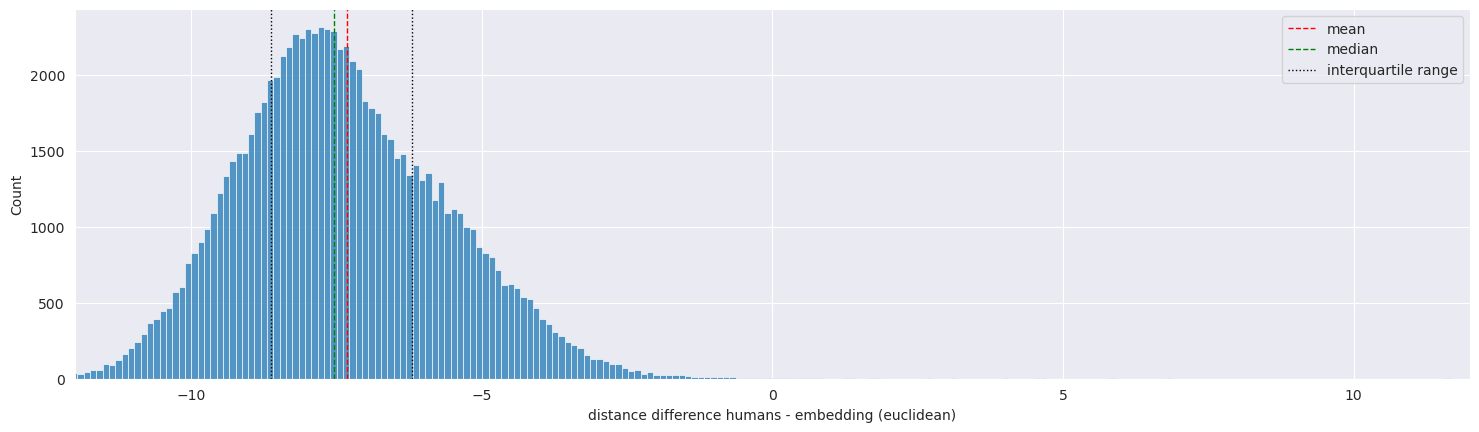

In [26]:
plt.figure().set_figwidth(18)
plt.xlim(-12,12)
sns.histplot(distance_differences_humans_euclidean)
# make the mean, median visible
plt.axvline(distance_differences_humans_euclidean.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(distance_differences_humans_euclidean.median(), color='green', linestyle='dashed', linewidth=1)
# show the 25th and 75th percentile
plt.axvline(distance_differences_humans_euclidean.quantile(0.25), color='black', linestyle='dotted', linewidth=1)
plt.axvline(distance_differences_humans_euclidean.quantile(0.75), color='black', linestyle='dotted', linewidth=1)
plt.legend(['mean', 'median', 'interquartile range'])
plt.xlabel('distance difference humans - embedding (euclidean)')

In [27]:
distance_differences_humans_euclidean.describe()

count    88517.000000
mean        -7.311655
std          2.545317
min        -13.373773
25%         -8.631836
50%         -7.542276
75%         -6.204247
max         59.167579
dtype: float64

### Any patterns in the article pairs where semantic distance differs the most between humans and LLM without memory?

In [28]:
# Get the 10% of pairs for which the LLM and human semantic distances differ the most
# Thomas does not see any clear pattern, but maybe you do?
distance_differences_humans_llm_no_memory[(distance_differences_humans_llm_no_memory < distance_differences_humans_llm_no_memory.quantile(0.05)) | (distance_differences_humans_llm_no_memory > distance_differences_humans_llm_no_memory.quantile(0.95))]

African_slave_trade  Africa                            0.509929
Atom                 Rain                             -0.781346
Ice_age              2004_Atlantic_hurricane_season   -0.424099
James_II_of_England  England                          -0.461627
Sweden               2005_Atlantic_hurricane_season    0.480643
                                                         ...   
Jupiter              United_Kingdom                    0.530887
Herodotus            Ancient_Egypt                     0.614041
Fiji                 United_States                     0.537410
Neoclassicism        Aesthetics                        1.625580
Kuwait               Salvador_Dalí                    -0.615001
Length: 1588, dtype: float64

### Does the human path length correlate with the human semantic distance between start and goal article?

Text(37.597222222222214, 0.5, 'Human semantic distance between start and end of path')

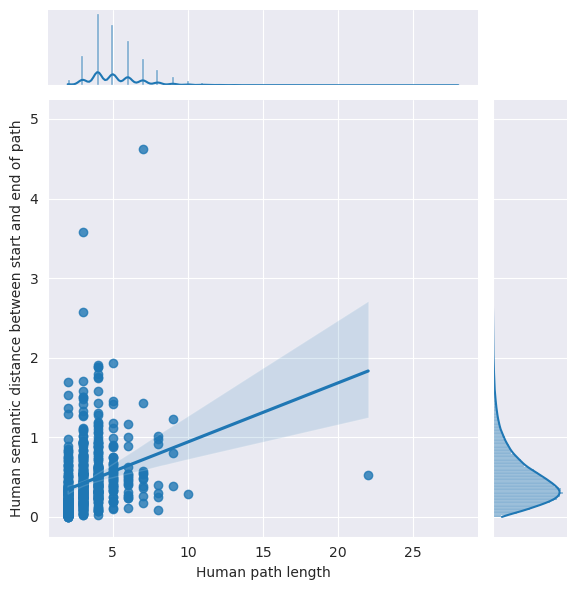

In [29]:
# Get the paths lengths indexed by the start and end pair
paths_len_humans_finished = pd.Series({ (path[0], path[-1]): len(path) for path in paths_finished_humans })
# Remove outliers
paths_len_humans_finished = paths_len_humans_finished[paths_len_humans_finished < 30]
distances_humans = distances_humans[distances_humans < 5]
# Plot path length against semantic distance between start and end
sns.jointplot(x=paths_len_humans_finished, y=distances_humans, kind='reg')
plt.xlabel('Human path length')
plt.ylabel('Human semantic distance between start and end of path')

In [30]:
# TODO compute Pearson and Spearman correlation coefficients
# TODO for this, we need to have series of the same length

Text(37.597222222222214, 0.5, 'LLM semantic distance between start and end of path')

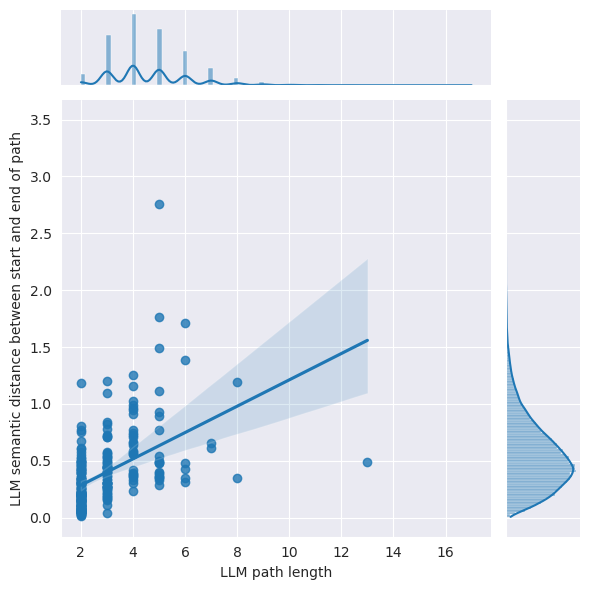

In [31]:
# Plot the same for LLM
series_paths_len_llm_finished = pd.Series({ (path[0], path[-1]): len(path) for path in paths_finished_llm_no_memory })
sns.jointplot(x=series_paths_len_llm_finished, y=distances_llm_no_memory, kind='reg')
plt.xlabel('LLM path length')
plt.ylabel('LLM semantic distance between start and end of path')

### Comparing llm and human paths

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib
import seaborn as sns

## Path with no memory

1. Does the llm take on average more steps than the human?

In [3]:
# load the data data/llm_paths_all_gpt4omini_no_memory.tsv
llm_paths_all_gpt4omini_no_memory = pd.read_csv('data/llm_paths_all_gpt4omini_no_memory.tsv', sep='\t')

# filter out the rows with 0 steps
llm_paths_all_gpt4omini_no_memory = llm_paths_all_gpt4omini_no_memory[llm_paths_all_gpt4omini_no_memory['steps'] > 0]
# describe the data
llm_paths_all_gpt4omini_no_memory['steps'].describe()

count    14527.000000
mean         3.661527
std          1.612817
min          1.000000
25%          3.000000
50%          3.000000
75%          5.000000
max         16.000000
Name: steps, dtype: float64

In [6]:
# load the data data/paths_finished_unique.tsv
paths_finished = pd.read_csv('data/paths_finished_unique.tsv', sep='\t')

# get the number of steps in the finished paths
paths_finished['path_length'] = paths_finished['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished['path_length'].describe()

count    28718.000000
mean         5.672749
std          5.017178
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max        434.000000
Name: path_length, dtype: float64

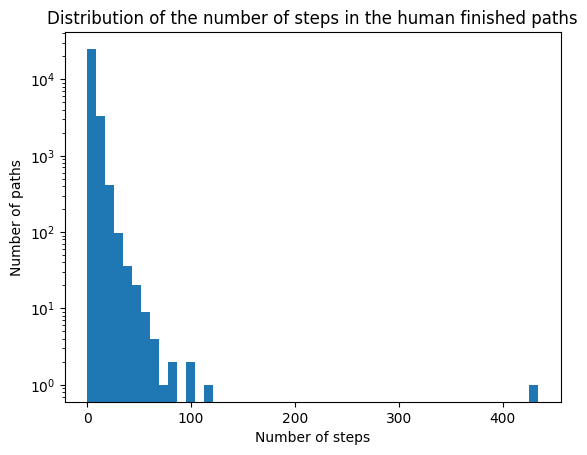

In [7]:
# plot the distribution of the number of steps in the finished paths
llm_paths_all_gpt4omini_no_memory['path_length'] = llm_paths_all_gpt4omini_no_memory['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished['path_length'].hist(bins=50)
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.title('Distribution of the number of steps in the human finished paths')
plt.grid(False)
plt.yscale('log')


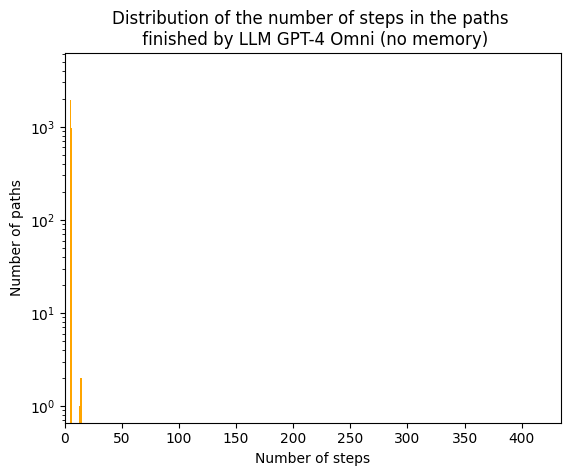

In [8]:
llm_paths_all_gpt4omini_no_memory['path_length'].hist(color='orange', bins=50)
plt.xlim(0, paths_finished['path_length'].max())
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.title('Distribution of the number of steps in the paths \n finished by LLM GPT-4 Omni (no memory)')
plt.grid(False)
plt.yscale('log')

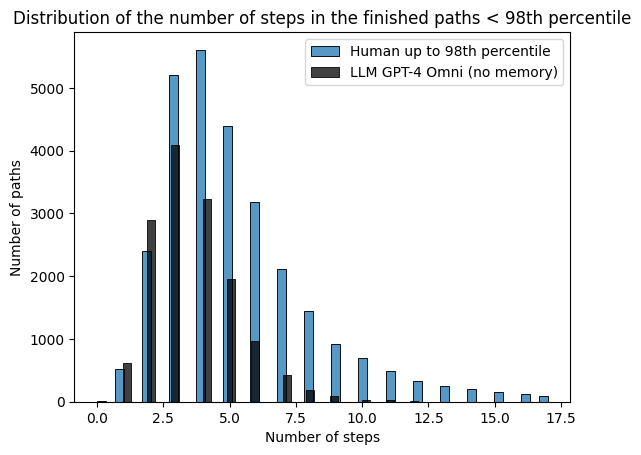

In [9]:
# get the 98th percentile of the number of steps in the finished paths
percentile_98 = np.percentile(paths_finished['path_length'], 98)

# get the number of steps in the finished paths that are less than the 98th percentile
paths_finished_lt_98 = paths_finished[paths_finished['path_length'] < percentile_98]
sns.histplot(paths_finished_lt_98['path_length'], bins=50, label='Human up to 98th percentile')
sns.histplot(llm_paths_all_gpt4omini_no_memory['path_length'], bins=50, color='black', label='LLM GPT-4 Omni (no memory)')
plt.title('Distribution of the number of steps in the finished paths < 98th percentile')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.legend()
plt.show()

In [10]:
# take only the path_id that are in the 2 datasets
# create a mask using the past_id column
mask = paths_finished['path_id'].isin(llm_paths_all_gpt4omini_no_memory['path_id'])
paths_finished_filtered = paths_finished[mask]


# get the number of steps in the filtered paths
paths_finished_filtered['path_length'] = paths_finished_filtered['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished_filtered['path_length'].describe()


C:\Users\ghita\AppData\Local\Temp\ipykernel_33648\3328009033.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_finished_filtered['path_length'] = paths_finished_filtered['path'].apply(lambda x: len(x.split(';')) - 1)


count    14527.000000
mean         4.747505
std          4.764334
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max        434.000000
Name: path_length, dtype: float64

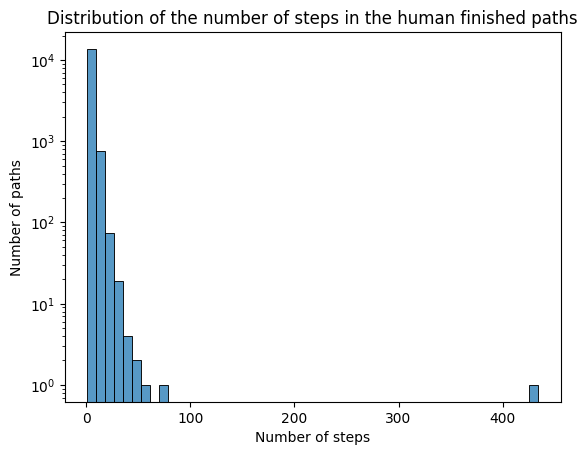

In [11]:
# plot the distribution of the number of steps in the filtered paths
sns.histplot(paths_finished_filtered['path_length'], bins=50)
plt.title('Distribution of the number of steps in the human finished paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.yscale('log')

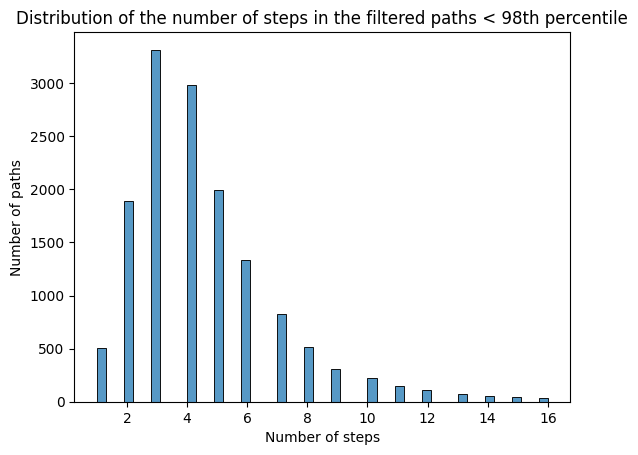

In [12]:
# get the 98th percentile of the number of steps in the filtered paths
percentile_99 = np.percentile(paths_finished_filtered['path_length'], 99)
# plot the distribution of the number of steps in the filtered paths that are less than the 98th percentile
paths_finished_filtered_lt_99 = paths_finished_filtered[paths_finished_filtered['path_length'] < percentile_99]
sns.histplot(paths_finished_filtered_lt_99['path_length'], bins=50)
plt.title('Distribution of the number of steps in the filtered paths < 98th percentile')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

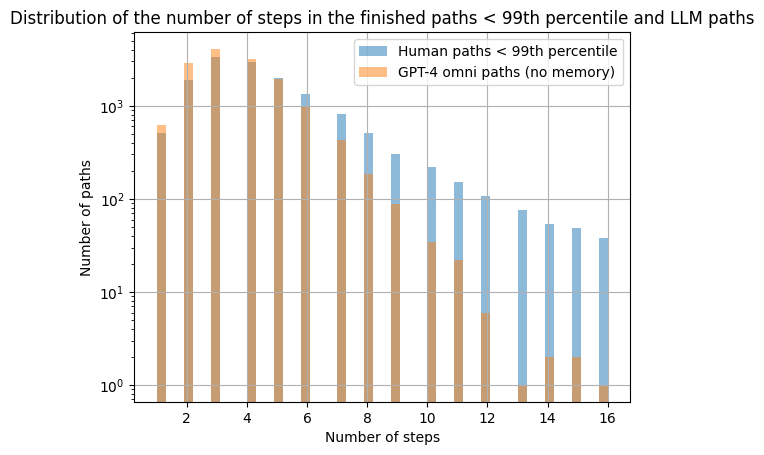

In [13]:
# compare the distribution of the number of steps in the finished paths filtered 99 percentile and the LLM paths
paths_finished_filtered_lt_99['path_length'].hist(bins=50, alpha=0.5, label='Human paths < 99th percentile')
llm_paths_all_gpt4omini_no_memory['path_length'].hist(bins=50, alpha=0.5, label='GPT-4 omni paths (no memory)')
plt.title('Distribution of the number of steps in the finished paths < 99th percentile and LLM paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.legend()
plt.yscale('log')
plt.show()

2. How does the llm work for unfinished paths?

In [14]:
DATA_FOLDER = 'data/wikispeedia_paths-and-graph/'
paths_unfinished = pd.read_csv(DATA_FOLDER + 'paths_unfinished.tsv', sep='\t', skiprows=16, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
paths_unfinished['path'] = paths_unfinished['path'].map(urllib.parse.unquote)

In [15]:
# for each row add a column containing the pair of the first article in the path and the target article
paths_unfinished['pair'] = paths_unfinished['path'].apply(lambda x: x.split(';')[0]) + ' -> ' + paths_unfinished['target']

print(paths_unfinished.head())

    hashedIpAddress   timestamp  durationInSec  \
0  2426091a53125110  1297054935           1804   
1  26141fd878806294  1297055651           1805   
2  2b015fb8181c48f2  1297090819           1818   
3  53a53bc244e08a6a  1297094761             49   
4  53a53bc244e08a6a  1297099105           1808   

                                   path            target     type  \
0                        Obi-Wan_Kenobi         Microsoft  timeout   
1                         Julius_Caesar           Caracas  timeout   
2  Malawi;Democracy;Alexander_the_Great     First_Crusade  timeout   
3                              Paraguay  Mount_St._Helens  restart   
4                      Paraguay;Bolivia  Mount_St._Helens  timeout   

                           pair  
0   Obi-Wan_Kenobi -> Microsoft  
1      Julius_Caesar -> Caracas  
2       Malawi -> First_Crusade  
3  Paraguay -> Mount_St._Helens  
4  Paraguay -> Mount_St._Helens  


In [16]:
# create a subset of the data by taking only one ocurrence of each pair
paths_unfinished_unique = paths_unfinished.drop_duplicates(subset='pair')

print(paths_unfinished_unique.head())


    hashedIpAddress   timestamp  durationInSec  \
0  2426091a53125110  1297054935           1804   
1  26141fd878806294  1297055651           1805   
2  2b015fb8181c48f2  1297090819           1818   
3  53a53bc244e08a6a  1297094761             49   
5  131600803df4895e  1297100557           2009   

                                                path                target  \
0                                     Obi-Wan_Kenobi             Microsoft   
1                                      Julius_Caesar               Caracas   
2               Malawi;Democracy;Alexander_the_Great         First_Crusade   
3                                           Paraguay      Mount_St._Helens   
5  Agriculture;History_of_the_world;China;Yangtze...  Grand_Canal_of_China   

      type                                 pair  
0  timeout          Obi-Wan_Kenobi -> Microsoft  
1  timeout             Julius_Caesar -> Caracas  
2  timeout              Malawi -> First_Crusade  
3  restart         Paraguay ->

In [17]:
# for each row add a column containing the pair of the first article in the path and the target article
paths_finished['pair'] = paths_finished['path'].apply(lambda x: x.split(';')[0] + ' -> ' + x.split(';')[-1])

# get the paths_unfinished_unique that are not in the paths_finished_unique
mask = ~paths_unfinished_unique['pair'].isin(paths_finished['pair'])
paths_unfinished_unique_filtered = paths_unfinished_unique[mask]

print(paths_unfinished_unique_filtered.head())
# get the number of unique paths_unfinished_unique_filtered
print(paths_unfinished_unique_filtered['pair'].nunique())

# store the paths_unfinished_unique_filtered
paths_unfinished_unique_filtered.to_csv('data/paths_unfinished_unique_filtered.tsv', sep='\t', index=False)

    hashedIpAddress   timestamp  durationInSec  \
1  26141fd878806294  1297055651           1805   
2  2b015fb8181c48f2  1297090819           1818   
5  131600803df4895e  1297100557           2009   
6  486bb79910fe9dd2  1297101660           1932   
7  6d136e371e42474f  1297102070            175   

                                                path                target  \
1                                      Julius_Caesar               Caracas   
2               Malawi;Democracy;Alexander_the_Great         First_Crusade   
5  Agriculture;History_of_the_world;China;Yangtze...  Grand_Canal_of_China   
6  Mind;Christianity;Europe;Renaissance;Ancient_G...              Scouting   
7    4-2-0;United_States;Agriculture;Sugar;Australia             Cane_Toad   

      type                                 pair  
1  timeout             Julius_Caesar -> Caracas  
2  timeout              Malawi -> First_Crusade  
5  timeout  Agriculture -> Grand_Canal_of_China  
6  timeout                    

The number of loop detected  626
The number of wrong answer  248
The number of dead end  96
The number of finished paths  426
Percentage of loop detected  0.4484240687679083
Percentage of wrong answer  0.17765042979942694
Percentage of dead end  0.06876790830945559
Percentage of finished paths  0.30515759312320917


Text(0.5, 1.0, 'Outcome of the paths generated by LLM on unfinished paths by humans')

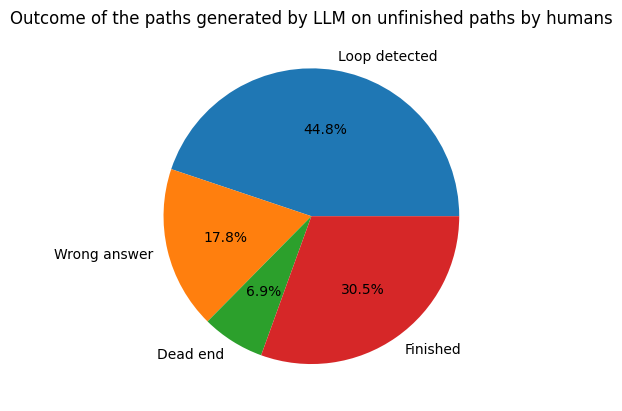

In [18]:
# load the data/llm_paths_unfinished.tsv
llm_paths_unfinished = pd.read_csv('data/llm_on_paths_unfinished.tsv', sep='\t')

# get the number of loop_detetected
# in the path column, if the last element is LOOP_DETECTED, then it is a loop
llm_paths_unfinished['loop_detected'] = llm_paths_unfinished['path'].apply(lambda x: x.split(';')[-1] == 'LOOP_DETECTED')

# print the number of loop_detected
print("The number of loop detected ",llm_paths_unfinished['loop_detected'].sum())

# get the number of wrong_answer
# in the path column, if the last element is WRONG_ANSWER, then it is a wrong answer
llm_paths_unfinished['wrong_answer'] = llm_paths_unfinished['path'].apply(lambda x: x.split(';')[-1] == 'WRONG_ANSWER')

# print the number of wrong_answer
print("The number of wrong answer ",llm_paths_unfinished['wrong_answer'].sum())

# get the number of paths that goes to a link with dead end
# in the path column, if the last element is NO_LINK, then it is a dead end
llm_paths_unfinished['no_link'] = llm_paths_unfinished['path'].apply(lambda x: x.split(';')[-1] == 'NO_LINK')

# print the number of no_link
print("The number of dead end ",llm_paths_unfinished['no_link'].sum())

# get the number of paths that finishes i.e. there is no LOOP_DETECTED, WRONG_ANSWER or NO_LINK
llm_paths_unfinished['finished'] = ~(llm_paths_unfinished['loop_detected'] | llm_paths_unfinished['wrong_answer'] | llm_paths_unfinished['no_link'])


# print the number of finished paths
print("The number of finished paths ",llm_paths_unfinished['finished'].sum())

# print the percentage of each
print("Percentage of loop detected ",llm_paths_unfinished['loop_detected'].sum() / len(llm_paths_unfinished))
print("Percentage of wrong answer ",llm_paths_unfinished['wrong_answer'].sum() / len(llm_paths_unfinished))
print("Percentage of dead end ",llm_paths_unfinished['no_link'].sum() / len(llm_paths_unfinished))
print("Percentage of finished paths ",llm_paths_unfinished['finished'].sum() / len(llm_paths_unfinished))

labels = 'Loop detected', 'Wrong answer', 'Dead end', 'Finished'
sizes = [llm_paths_unfinished['loop_detected'].sum(), llm_paths_unfinished['wrong_answer'].sum(), llm_paths_unfinished['no_link'].sum(), llm_paths_unfinished['finished'].sum()]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Outcome of the paths generated by LLM on unfinished paths by humans')


In [19]:
# filter out the rows with 0 steps
llm_paths_unfinished = llm_paths_unfinished[llm_paths_unfinished['steps'] > 0]
# describe the data
llm_paths_unfinished['steps'].describe()

count    426.000000
mean       5.661972
std        3.545776
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       25.000000
Name: steps, dtype: float64

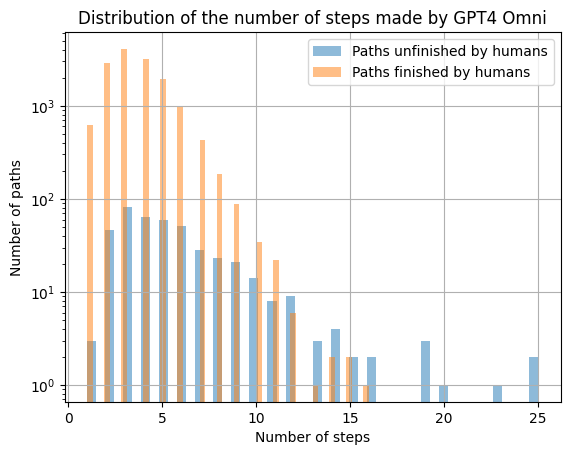

In [20]:
llm_paths_unfinished['steps'].hist(bins=50, alpha=0.5, label='Paths unfinished by humans')
llm_paths_all_gpt4omini_no_memory['path_length'].hist(bins=50, alpha=0.5, label='Paths finished by humans')
plt.title('Distribution of the number of steps made by GPT4 Omni')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.legend()
plt.yscale('log')
plt.show()

3. What is the distribution of the categories of articles passed by the llm or by the human?

In [21]:
# get the articles that llm goes to
llm_paths_all_gpt4omini_no_memory = pd.read_csv('data/llm_paths_all_gpt4omini_no_memory.tsv', sep='\t')

print("The number of paths ",len(llm_paths_all_gpt4omini_no_memory))
# get the articles that human goes to
articles_llm = llm_paths_all_gpt4omini_no_memory['path'].apply(lambda x: x.split(';')).tolist()

# ignore the "<" articles in the path
articles_llm = [[item for item in sublist if item[0] != '<'] for sublist in articles_llm]

# get the categories of the articles
file_path = "data/wikispeedia_paths-and-graph/categories.tsv"
categories = pd.read_csv(file_path, sep='\t', skiprows=12, names=['article', 'category'])
categories = categories.map(urllib.parse.unquote)

articles_llm = [item for sublist in articles_llm for item in sublist]
# get the categories of the articles
categories_of_articles_llm = []
for article in articles_llm:
    try:
        categories_of_articles_llm.append(categories[categories['article'] == article]['category'])
    except:
        pass


# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_llm = [item for sublist in categories_of_articles_llm for item in sublist]
categories_count_llm = pd.Series(categories_of_articles_llm).value_counts()

# print the 5 most common categories
print(categories_count_llm.head())
nbr = categories_count_llm.quantile(0.70)

The number of paths  28718
subject.Countries                                          17316
subject.Science.Biology.General_Biology                     7016
subject.Geography.European_Geography.European_Countries     6374
subject.Geography.Geography_of_Great_Britain                5235
subject.Geography.North_American_Geography                  4791
Name: count, dtype: int64


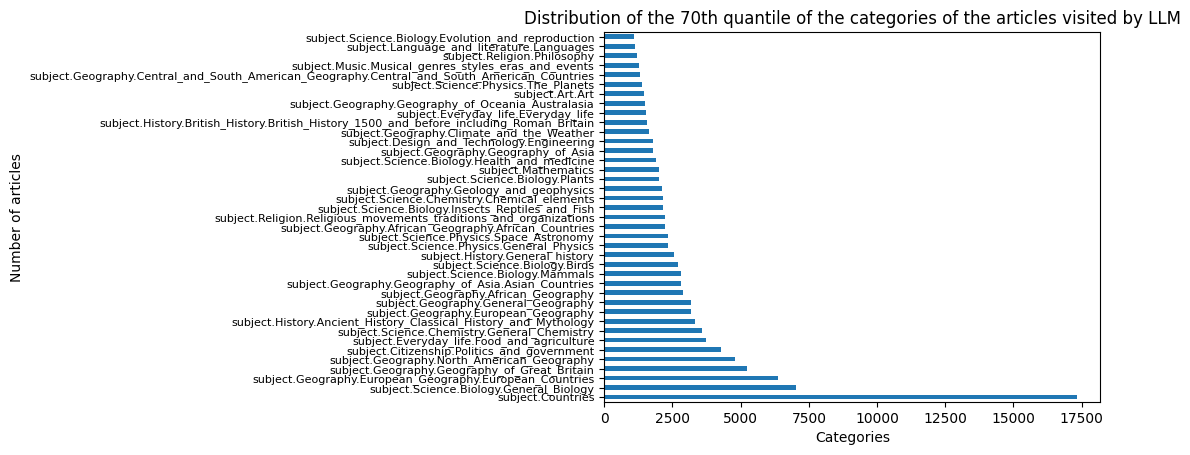

In [ ]:
# plot the distribution of the 70th quantile
categories_count_llm[categories_count_llm > nbr].plot(kind='barh')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by LLM')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.yticks(fontsize=8)
plt.show()

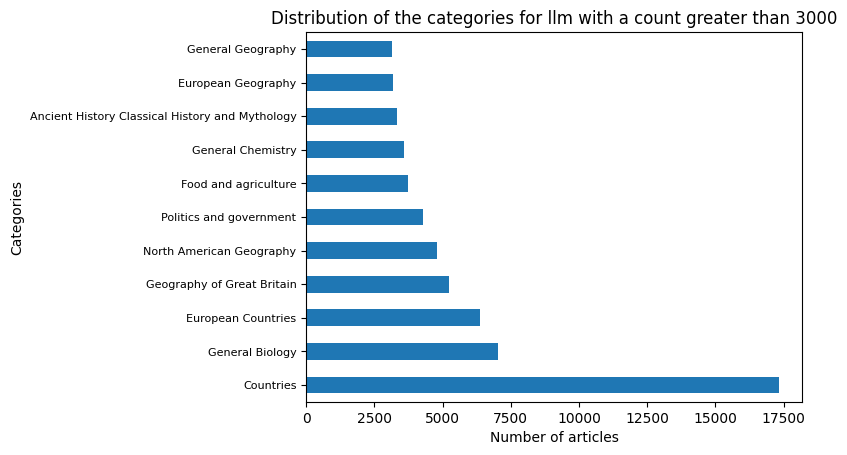

In [ ]:
# make the category names more readable
categories_count_llm.index = categories_count_llm.index.str.split('.').map(lambda x: x[-1]).str.replace('_', ' ')
# plot the distribution of the categories with a count greater than 3000
categories_count_llm[categories_count_llm > 3000].plot(kind='barh')
plt.title('Distribution of the categories for llm with a count greater than 3000')
plt.ylabel('Categories')
plt.xlabel('Number of articles')
plt.yticks(fontsize=8)
plt.show()

In [ ]:
# get the articles that human goes to
articles_human = paths_finished['path'].apply(lambda x: x.split(';')).tolist()

# ignore the "<" articles in the path
articles_human = [[item for item in sublist if item[0] != '<'] for sublist in articles_human]

print("The number of paths ",len(paths_finished))

articles_human = [item for sublist in articles_human for item in sublist]
# get the cartegoies of the articles
categories_of_articles_human = []
for article in articles_human:
    try:
        categories_of_articles_human.append(categories[categories['article'] == article]['category'])
    except:
        pass


# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_human = [item for sublist in categories_of_articles_human for item in sublist]
categories_count_human = pd.Series(categories_of_articles_human).value_counts()

# print the 5 most common categories
print(categories_count_human.head())
nbr_h = categories_count_human.quantile(0.70)

The number of paths  28718
subject.Countries                                          25739
subject.Geography.North_American_Geography                 10157
subject.Geography.European_Geography.European_Countries     9503
subject.Geography.Geography_of_Great_Britain                8169
subject.Geography.General_Geography                         6106
Name: count, dtype: int64


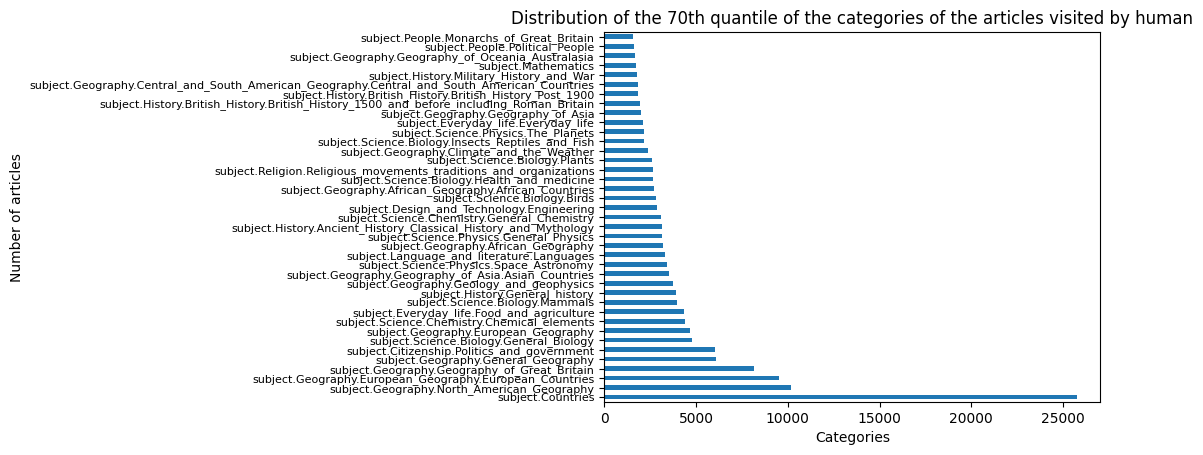

In [ ]:
# plot the distribution of the 70th quantile
categories_count_human[categories_count_human > nbr_h].plot(kind='barh')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by human')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.yticks(fontsize=8)
plt.show()

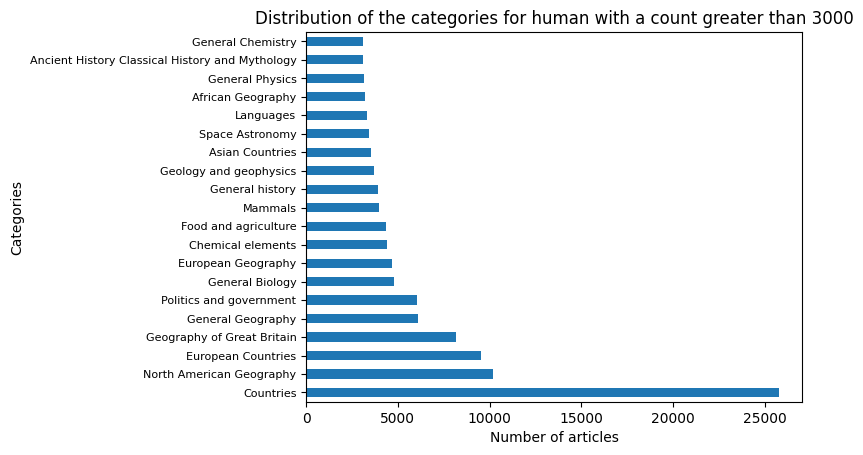

In [ ]:
# make the category names more readable
categories_count_human.index = categories_count_human.index.str.split('.').map(lambda x: x[-1]).str.replace('_', ' ')
# plot the distribution of the categories with a count greater than 3000
categories_count_human[categories_count_human > 3000].plot(kind='barh')
plt.title('Distribution of the categories for human with a count greater than 3000')
plt.ylabel('Categories')
plt.xlabel('Number of articles')
plt.yticks(fontsize=8)
plt.show()

4. What is the distribution of the articles passed by the llm or by the human?

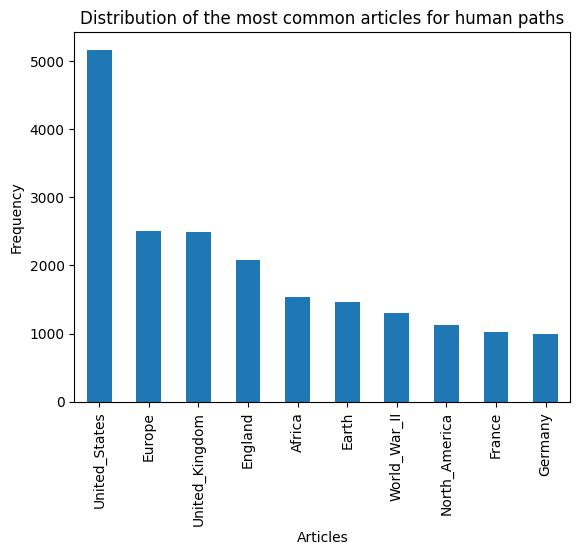

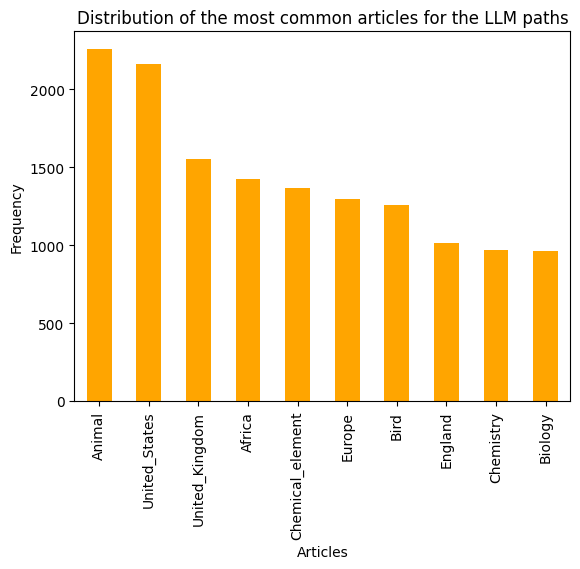

In [ ]:

# Plot the distribution of the most common articles
articles_count_h = pd.Series(articles_human)
articles_count_h = articles_count_h.value_counts()
articles_count_h = articles_count_h.sort_values(ascending=False)
articles_count_h = articles_count_h[:10]
articles_count_h.plot(kind='bar')
plt.title('Distribution of the most common articles for human paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()


# from articles_llm, drop the loop_detected, wrong_answer and no_link
articles_llm = [item for item in articles_llm if item not in ['LOOP_DETECTED', 'WRONG_ANSWER', 'NO_LINK']]


# Plot the distribution of the most common articles
articles_count = pd.Series(articles_llm)
articles_count = articles_count.value_counts()
articles_count = articles_count.sort_values(ascending=False)
articles_count = articles_count[:10]
articles_count.plot(kind='bar', color='orange')
plt.title('Distribution of the most common articles for the LLM paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()



United_States     5163
Europe            2502
United_Kingdom    2489
England           2073
Africa            1537
Earth             1456
World_War_II      1305
North_America     1128
France            1026
Germany            990
Name: count, dtype: int64
Animal              2259
United_States       2161
United_Kingdom      1553
Africa              1427
Chemical_element    1368
Europe              1295
Bird                1257
England             1013
Chemistry            968
Biology              966
Name: count, dtype: int64
the number of articles passes from human 19669
14267


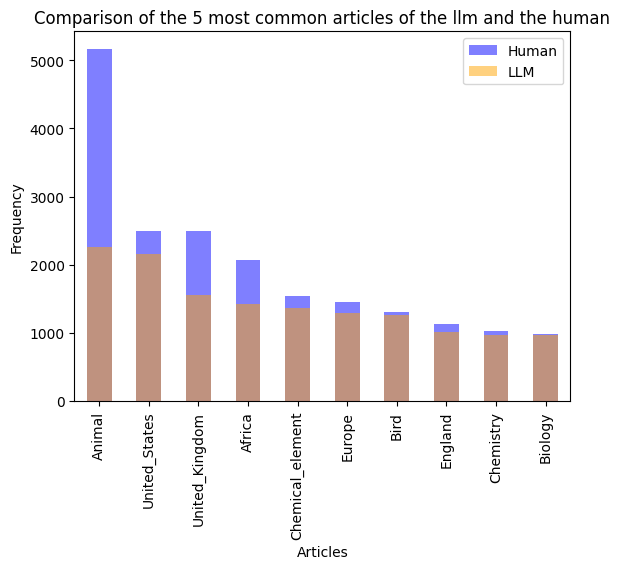

In [ ]:
# plot a comparison of the 10 most common articles of the llm and the human
print(articles_count_h)
print(articles_count)

print("the number of articles passes from human", articles_count_h.sum())
print(articles_count.sum())

articles_count_h.plot(kind='bar', alpha=0.5, color = 'blue', label='Human')
articles_count.plot(kind='bar', alpha=0.5, color = 'orange', label='LLM')
plt.title('Comparison of the 5 most common articles of the llm and the human')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Some info about the outgoing and incoming links of the two most common articles.

In [ ]:
links = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv', sep='\t', skiprows=12, names=['article', 'link'])
# group all links by their origin article
links = links.groupby('article')['link'].apply(list).reset_index(name='links')
links['outgoing_number']=links['links'].apply(lambda x: len(x))
print("The number of outgoing articles from the article 'United States':", links[links['article'] == 'United_States']['outgoing_number'].values[0])

The number of outgoing articles from the article 'United States': 294


In [ ]:
print("The number of outgoing articles from the article 'Animal':", links[links['article'] == 'Animal']['outgoing_number'].values[0])

The number of outgoing articles from the article 'Animal': 29


In [ ]:
# get the number of incoming links for each article
# create a list of all articles that are linked to the article
incoming_links = []
for index, row in links.iterrows():
    for link in row['links']:
        incoming_links.append(link)
incoming_links = pd.Series(incoming_links)

incoming_links = incoming_links.value_counts()
incoming_links = incoming_links.reset_index()
incoming_links.columns = ['article', 'incoming_number']
print("The number of incoming articles to the article 'United States':", incoming_links[incoming_links['article'] == 'United_States']['incoming_number'].values[0])

The number of incoming articles to the article 'United States': 1551


In [ ]:
print("The number of incoming articles to the article 'Animal':", incoming_links[incoming_links['article'] == 'Animal']['incoming_number'].values[0])

The number of incoming articles to the article 'Animal': 492


# Paths with memory 

Does the llm take on average more steps than the human?

In [ ]:
# load the data data/llm_paths_all_gpt4omini_memory.tsv
llm_paths_all_gpt4omini_memory = pd.read_csv('data/llm_paths_all_gpt4omini_memory.tsv', sep='\t')

# filter out the rows with 0 steps
llm_paths_all_gpt4omini_memory = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['steps'] > 0]
# describe the data
llm_paths_all_gpt4omini_memory['steps'].describe()

count    7552.000000
mean        6.983316
std         4.778942
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        57.000000
Name: steps, dtype: float64

In [ ]:
# load the data data/paths_finished_unique.tsv
paths_finished = pd.read_csv('data/paths_finished_unique.tsv', sep='\t')

# get the number of steps in the finished paths
paths_finished['path_length'] = paths_finished['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished['path_length'].describe()

count    28718.000000
mean         5.672749
std          5.017178
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max        434.000000
Name: path_length, dtype: float64

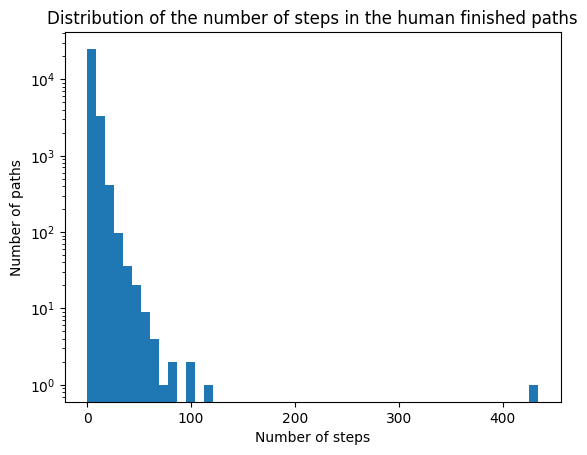

In [ ]:
# plot the distribution of the number of steps in the finished paths
llm_paths_all_gpt4omini_memory['path_length'] = llm_paths_all_gpt4omini_memory['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished['path_length'].hist(bins=50)
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.title('Distribution of the number of steps in the human finished paths')
plt.grid(False)
plt.yscale('log')


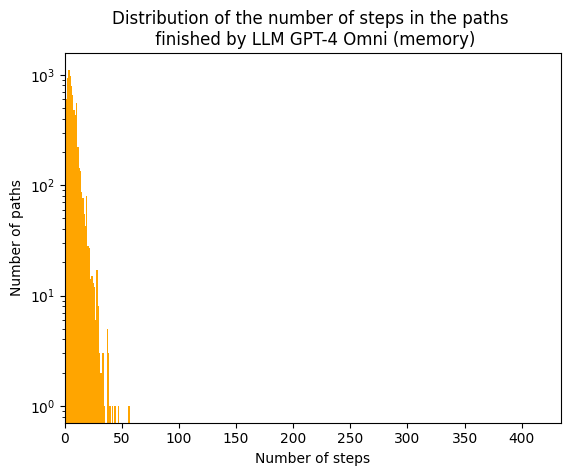

In [ ]:
llm_paths_all_gpt4omini_memory['path_length'].hist(color='orange', bins=50)
plt.xlim(0, paths_finished['path_length'].max())
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.title('Distribution of the number of steps in the paths \n finished by LLM GPT-4 Omni (memory)')
plt.grid(False)
plt.yscale('log')

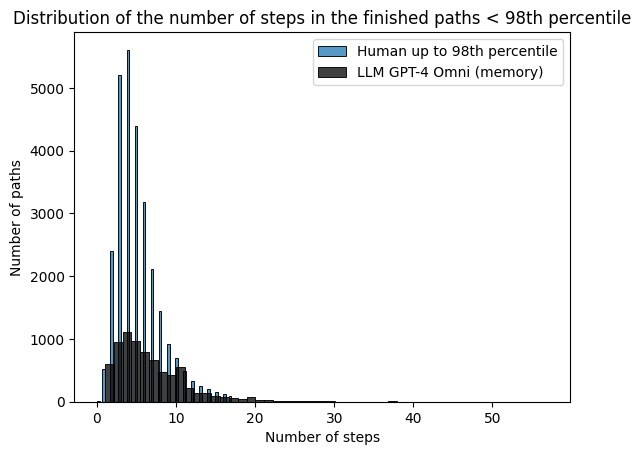

In [ ]:
# get the 98th percentile of the number of steps in the finished paths
percentile_98 = np.percentile(paths_finished['path_length'], 98)

# get the number of steps in the finished paths that are less than the 98th percentile
paths_finished_lt_98 = paths_finished[paths_finished['path_length'] < percentile_98]
sns.histplot(paths_finished_lt_98['path_length'], bins=50, label='Human up to 98th percentile')
sns.histplot(llm_paths_all_gpt4omini_memory['path_length'], bins=50, color='black', label='LLM GPT-4 Omni (memory)')
plt.title('Distribution of the number of steps in the finished paths < 98th percentile')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.legend()
plt.show()

In [ ]:
# take only the path_id that are in the 2 datasets
# create a mask using the past_id column
mask = paths_finished['path_id'].isin(llm_paths_all_gpt4omini_memory['path_id'])
paths_finished_filtered = paths_finished[mask]


# get the number of steps in the filtered paths
paths_finished_filtered['path_length'] = paths_finished_filtered['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished_filtered['path_length'].describe()


C:\Users\ghita\AppData\Local\Temp\ipykernel_36052\695916232.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_finished_filtered['path_length'] = paths_finished_filtered['path'].apply(lambda x: len(x.split(';')) - 1)


count    7552.000000
mean        5.566870
std         6.244099
min         1.000000
25%         3.000000
50%         5.000000
75%         6.000000
max       434.000000
Name: path_length, dtype: float64

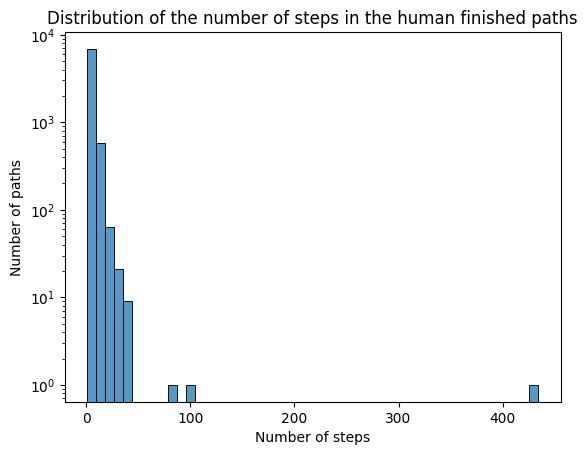

In [ ]:
# plot the distribution of the number of steps in the filtered paths
sns.histplot(paths_finished_filtered['path_length'], bins=50)
plt.title('Distribution of the number of steps in the human finished paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.yscale('log')

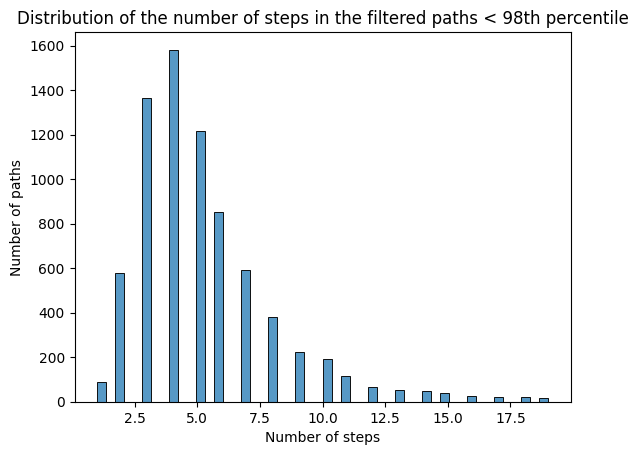

In [ ]:
# get the 98th percentile of the number of steps in the filtered paths
percentile_99 = np.percentile(paths_finished_filtered['path_length'], 99)
# plot the distribution of the number of steps in the filtered paths that are less than the 98th percentile
paths_finished_filtered_lt_99 = paths_finished_filtered[paths_finished_filtered['path_length'] < percentile_99]
sns.histplot(paths_finished_filtered_lt_99['path_length'], bins=50)
plt.title('Distribution of the number of steps in the filtered paths < 98th percentile')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

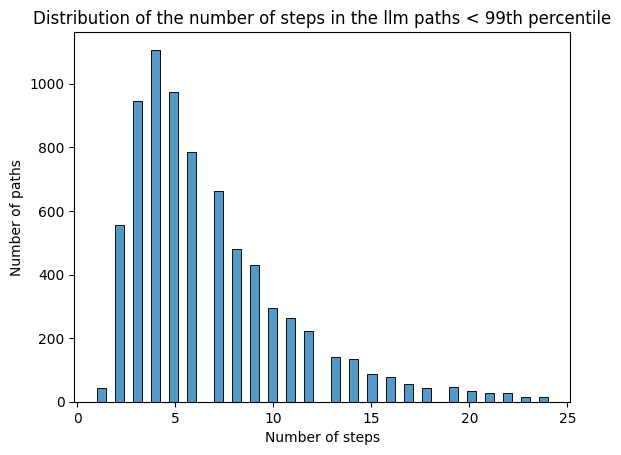

In [ ]:
# get the 99th percentile of the number of steps in the llm paths with memory
percentile_99 = np.percentile(llm_paths_all_gpt4omini_memory['path_length'], 99)

# plot the distribution of the number of steps in the llm paths that are less than the 90th percentile
llm_paths_all_gpt4omini_memory_lt_99 = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['path_length'] < percentile_99]
sns.histplot(llm_paths_all_gpt4omini_memory_lt_99['path_length'], bins=50)
plt.title('Distribution of the number of steps in the llm paths < 99th percentile')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

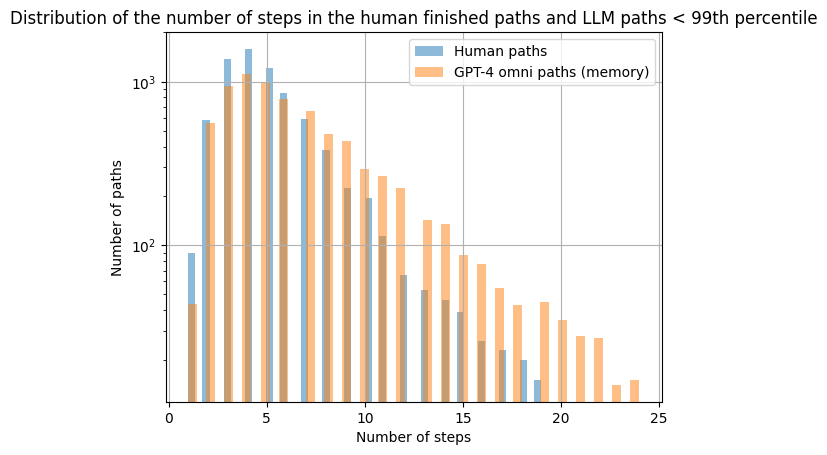

In [ ]:
# compare the distribution of the number of steps in the finished paths filtered 99 percentile and the LLM paths filtered 90 percentile
paths_finished_filtered_lt_99['path_length'].hist(bins=50, alpha=0.5, label='Human paths')
llm_paths_all_gpt4omini_memory_lt_99['path_length'].hist(bins=50, alpha=0.5, label='GPT-4 omni paths (memory)')
plt.title('Distribution of the number of steps in the human finished paths and LLM paths < 99th percentile')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.legend()
plt.yscale('log')
plt.show()

What is the distribution of the categories of articles passed by the llm or by the human?

In [ ]:
# get the articles that llm goes to
llm_paths_all_gpt4omini_memory = pd.read_csv('data/llm_paths_all_gpt4omini_memory.tsv', sep='\t')

print("The number of paths ",len(llm_paths_all_gpt4omini_memory))
# get the articles that human goes to
articles_llm = llm_paths_all_gpt4omini_memory['path'].apply(lambda x: x.split(';')).tolist()

# ignore the "<" articles in the path
articles_llm = [[item for item in sublist if item[0] != '<'] for sublist in articles_llm]

# get the categories of the articles
file_path = "data/wikispeedia_paths-and-graph/categories.tsv"
categories = pd.read_csv(file_path, sep='\t', skiprows=12, names=['article', 'category'])
categories = categories.map(urllib.parse.unquote)

articles_llm = [item for sublist in articles_llm for item in sublist]
# get the categories of the articles
categories_of_articles_llm = []
for article in articles_llm:
    try:
        categories_of_articles_llm.append(categories[categories['article'] == article]['category'])
    except:
        pass


# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_llm = [item for sublist in categories_of_articles_llm for item in sublist]
categories_count_llm = pd.Series(categories_of_articles_llm).value_counts()

# print the 5 most common categories
print(categories_count_llm.head())
nbr = categories_count_llm.quantile(0.70)

The number of paths  13410
subject.Countries                                                  13368
subject.Science.Biology.General_Biology                             7519
subject.History.Ancient_History_Classical_History_and_Mythology     4973
subject.Geography.European_Geography.European_Countries             4754
subject.Citizenship.Politics_and_government                         4139
Name: count, dtype: int64


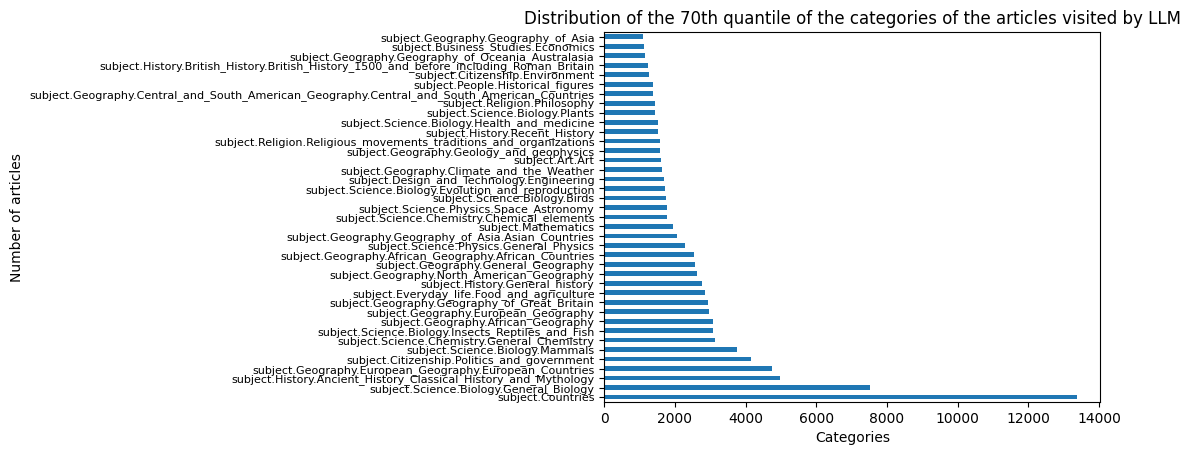

In [ ]:
# plot the distribution of the 70th quantile
categories_count_llm[categories_count_llm > nbr].plot(kind='barh')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by LLM')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.yticks(fontsize=8)
plt.show()

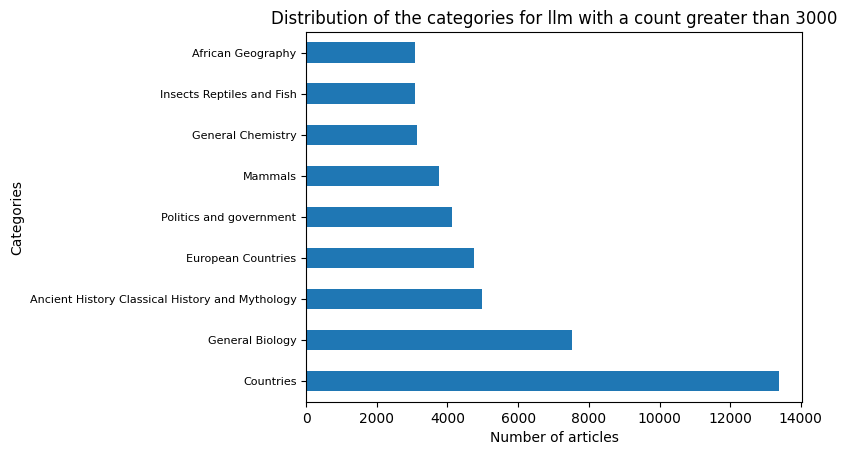

In [ ]:
# make the category names more readable
categories_count_llm.index = categories_count_llm.index.str.split('.').map(lambda x: x[-1]).str.replace('_', ' ')
# plot the distribution of the categories with a count greater than 3000
categories_count_llm[categories_count_llm > 3000].plot(kind='barh')
plt.title('Distribution of the categories for llm with a count greater than 3000')
plt.ylabel('Categories')
plt.xlabel('Number of articles')
plt.yticks(fontsize=8)
plt.show()

In [ ]:
# get the articles that human goes to
articles_human = paths_finished['path'].apply(lambda x: x.split(';')).tolist()

# ignore the "<" articles in the path
articles_human = [[item for item in sublist if item[0] != '<'] for sublist in articles_human]

print("The number of paths ",len(paths_finished))

articles_human = [item for sublist in articles_human for item in sublist]
# get the cartegoies of the articles
categories_of_articles_human = []
for article in articles_human:
    try:
        categories_of_articles_human.append(categories[categories['article'] == article]['category'])
    except:
        pass


# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_human = [item for sublist in categories_of_articles_human for item in sublist]
categories_count_human = pd.Series(categories_of_articles_human).value_counts()

# print the 5 most common categories
print(categories_count_human.head())
nbr_h = categories_count_human.quantile(0.70)

The number of paths  28718
subject.Countries                                          25739
subject.Geography.North_American_Geography                 10157
subject.Geography.European_Geography.European_Countries     9503
subject.Geography.Geography_of_Great_Britain                8169
subject.Geography.General_Geography                         6106
Name: count, dtype: int64


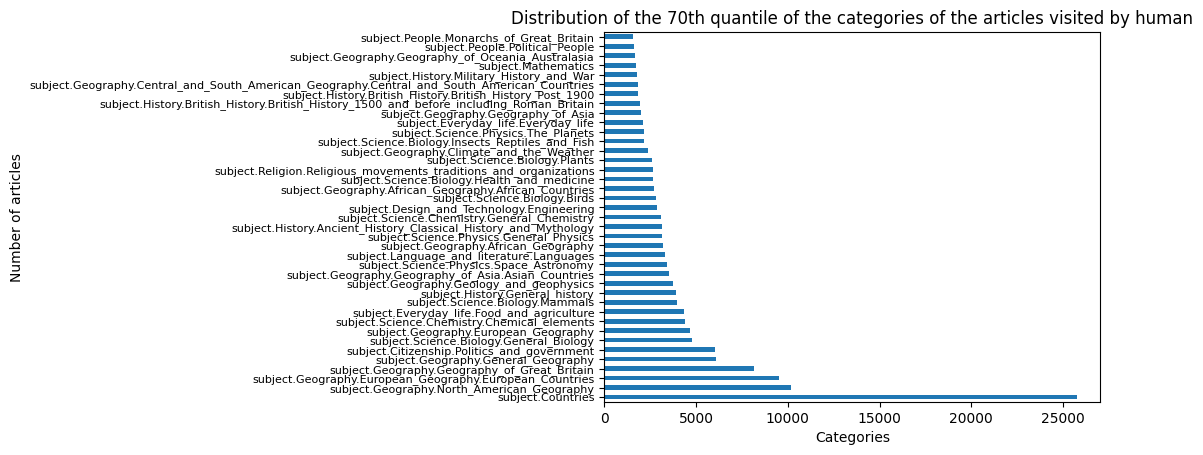

In [ ]:
# plot the distribution of the 70th quantile
categories_count_human[categories_count_human > nbr_h].plot(kind='barh')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by human')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.yticks(fontsize=8)
plt.show()

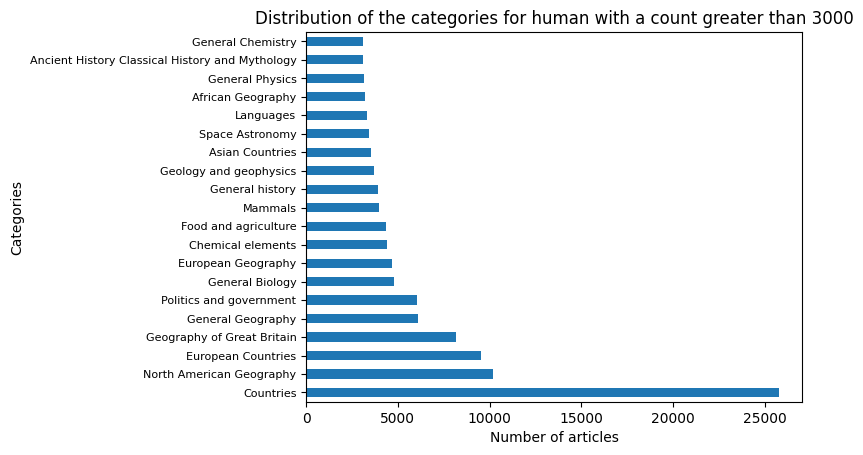

In [ ]:
# make the category names more readable
categories_count_human.index = categories_count_human.index.str.split('.').map(lambda x: x[-1]).str.replace('_', ' ')
# plot the distribution of the categories with a count greater than 3000
categories_count_human[categories_count_human > 3000].plot(kind='barh')
plt.title('Distribution of the categories for human with a count greater than 3000')
plt.ylabel('Categories')
plt.xlabel('Number of articles')
plt.yticks(fontsize=8)
plt.show()

Now we compare the articles passed by the llm and the human. Does the llm pass more articles than the human?

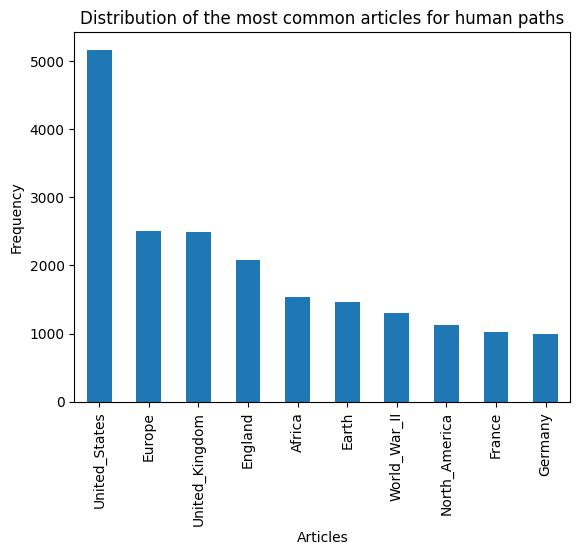

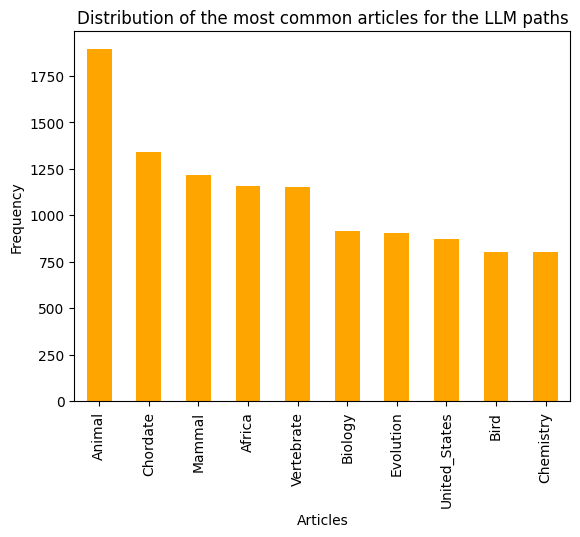

In [ ]:

# Plot the distribution of the most common articles
articles_count_h = pd.Series(articles_human)
articles_count_h = articles_count_h.value_counts()
articles_count_h = articles_count_h.sort_values(ascending=False)
articles_count_h = articles_count_h[:10]
articles_count_h.plot(kind='bar')
plt.title('Distribution of the most common articles for human paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()


# from articles_llm, drop the loop_detected, wrong_answer and no_link
articles_llm = [item for item in articles_llm if item not in ['LOOP_DETECTED', 'WRONG_ANSWER', 'NO_LINK']]


# Plot the distribution of the most common articles
articles_count = pd.Series(articles_llm)
articles_count = articles_count.value_counts()
articles_count = articles_count.sort_values(ascending=False)
articles_count = articles_count[:10]
articles_count.plot(kind='bar', color='orange')
plt.title('Distribution of the most common articles for the LLM paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()



In [ ]:
# plot a comparison of the 10 most common articles of the llm and the human
print(articles_count_h)
print(articles_count)

print("the number of articles passes from human", articles_count_h.sum())
print(articles_count.sum())


United_States     5163
Europe            2502
United_Kingdom    2489
England           2073
Africa            1537
Earth             1456
World_War_II      1305
North_America     1128
France            1026
Germany            990
Name: count, dtype: int64
Animal           1893
Chordate         1338
Mammal           1218
Africa           1158
Vertebrate       1149
Biology           914
Evolution         906
United_States     870
Bird              803
Chemistry         802
Name: count, dtype: int64
the number of articles passes from human 19669
11051


### Comparing OpenAi LLM with MistralAI LLM

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

We begin by finding the number of rows to get a statistical significant result.

In [ ]:
# get the number of rows in the data
paths_finished = pd.read_csv('data/paths_finished_unique.tsv', sep='\t', skiprows=1, names=['path_id', 'hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
print('Number of rows in paths_finished:', paths_finished.shape[0])

Number of rows in paths_finished: 28718


In [ ]:
# as the data is too large, we can calculate the necessary number of rows using the Z-score
# Z-score = 1.96 for 95% confidence interval
# margin of error = 5%
# population proportion = 0.5
Z = 1.96
margin_of_error = 0.05
p = 0.5
n = (Z**2 * p * (1-p)) / margin_of_error**2
print('Number of rows needed:', n)

Number of rows needed: 384.1599999999999


Using the Z-score, for a 95% confidence interval, the minimum number of rows needed to get a statistical significant result is 385. We therefore take randomly 565 rows from the dataset.

In [23]:
# Load the merged_file_mistral.tsv file
# Load the TSV file
file_path = "data/merged_file_final_mistral.tsv"
df_mistral = pd.read_csv(file_path, sep="\t")


In [24]:
# load the data/llm_paths.tsv file
# Load the TSV file
file_path = "data/llm_paths_all_gpt4omini_no_memory.tsv"
df_openai = pd.read_csv(file_path, sep="\t")

In [25]:
# print the number of rows in the df_openai DataFrame
num_rows = df_openai.shape[0]
print(f"Number of rows in the file: {num_rows}")

# print the number of rows in the df_mistral DataFrame
num_rows = df_mistral.shape[0]
print(f"Number of rows in the file: {num_rows}")    

Number of rows in the file: 28718
Number of rows in the file: 565


In [26]:
# get only the rows in the openai file that have the same path_id as the mistral file
# get the path_ids from the mistral file
mistral_path_ids = df_mistral["path_id"]

# filter the openai file based on the path_ids
df_openai = df_openai[df_openai["path_id"].isin(mistral_path_ids)]

In [27]:
# get only the rows in the mistral file that have the same path_id as the openai file
# get the path_ids from the openai file
openai_path_ids = df_openai["path_id"]

# filter the mistral file based on the path_ids
df_mistral = df_mistral[df_mistral["path_id"].isin(openai_path_ids)]


In [28]:
# get the number of rows in the filtered openai file
num_rows_filtered = df_openai.shape[0]
print(f"Number of rows in the filtered file: {num_rows}")

# get the number of rows in the filtered mistral file
num_rows_filtered = df_mistral.shape[0]
print(f"Number of rows in the filtered file: {num_rows}")

Number of rows in the filtered file: 565
Number of rows in the filtered file: 565


In [29]:
# check if the path of each row contain the string "WRONG_ANSWER"
df_openai_WA = df_openai[df_openai['path'].str.contains("WRONG_ANSWER")]
df_mistral_WA = df_mistral[df_mistral['path'].str.contains("WRONG_ANSWER")]

# get the number of rows in the df_openai_WA and df_mistral_WA DataFrames
num_rows_openai_WA = df_openai_WA.shape[0]
num_rows_mistral_WA = df_mistral_WA.shape[0]

print(f"Number of rows in the OpenAI file with 'WRONG_ANSWER': {num_rows_openai_WA}")
print(f"Number of rows in the Mistral file with 'WRONG_ANSWER': {num_rows_mistral_WA}")

# get the pourcentage of wrong answers 
pourcentage_openai_WA = (num_rows_openai_WA/num_rows)*100
pourcentage_mistral_WA = (num_rows_mistral_WA/num_rows)*100

print(f"Pourcentage of wrong answers in the OpenAI file: {pourcentage_openai_WA}%")
print(f"Pourcentage of wrong answers in the Mistral file: {pourcentage_mistral_WA}%")

Number of rows in the OpenAI file with 'WRONG_ANSWER': 28
Number of rows in the Mistral file with 'WRONG_ANSWER': 186
Pourcentage of wrong answers in the OpenAI file: 4.95575221238938%
Pourcentage of wrong answers in the Mistral file: 32.92035398230089%


In [30]:
# check if the path of each row contain the string "LOOP_DETECTED"
df_openai_LD = df_openai[df_openai['path'].str.contains("LOOP_DETECTED")]
df_mistral_LD = df_mistral[df_mistral['path'].str.contains("LOOP_DETECTED")]

# get the number of rows in the df_openai_LD and df_mistral_LD DataFrames
num_rows_openai_LD = df_openai_LD.shape[0]
num_rows_mistral_LD = df_mistral_LD.shape[0]

print(f"Number of rows in the OpenAI file with 'LOOP_DETECTED': {num_rows_openai_LD}")
print(f"Number of rows in the Mistral file with 'LOOP_DETECTED': {num_rows_mistral_LD}")

# get the pourcentage of loop detected
pourcentage_openai_LD = (num_rows_openai_LD/num_rows)*100
pourcentage_mistral_LD = (num_rows_mistral_LD/num_rows)*100

print(f"Pourcentage of loop detected in the OpenAI file: {pourcentage_openai_LD}%")
print(f"Pourcentage of loop detected in the Mistral file: {pourcentage_mistral_LD}%")

Number of rows in the OpenAI file with 'LOOP_DETECTED': 225
Number of rows in the Mistral file with 'LOOP_DETECTED': 82
Pourcentage of loop detected in the OpenAI file: 39.823008849557525%
Pourcentage of loop detected in the Mistral file: 14.513274336283185%


Number of finished paths in the OpenAI file: 312
Number of finished paths in the Mistral file: 297
Pourcentage of finished paths in the OpenAI file: 55.2212389380531%
Pourcentage of finished paths in the Mistral file: 52.56637168141592%


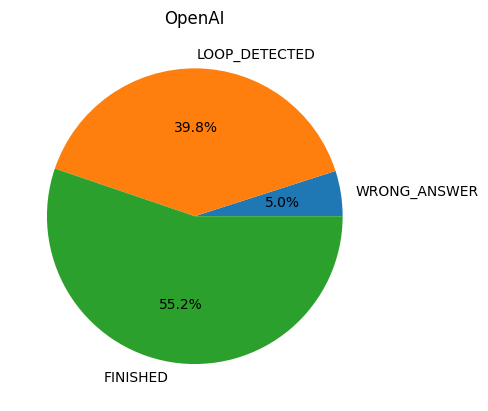

Text(0.5, 1.0, 'Mistral')

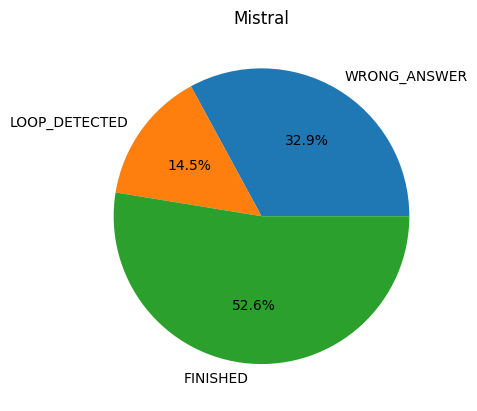

In [31]:
# the number of finished paths is therefore all the other paths
num_rows_openai_finished = num_rows_filtered - num_rows_openai_WA - num_rows_openai_LD
num_rows_mistral_finished = num_rows_filtered - num_rows_mistral_WA - num_rows_mistral_LD

print(f"Number of finished paths in the OpenAI file: {num_rows_openai_finished}")
print(f"Number of finished paths in the Mistral file: {num_rows_mistral_finished}")

# get the pourcentage of finished paths
pourcentage_openai_finished = (num_rows_openai_finished/num_rows_filtered)*100
pourcentage_mistral_finished = (num_rows_mistral_finished/num_rows_filtered)*100

print(f"Pourcentage of finished paths in the OpenAI file: {pourcentage_openai_finished}%")
print(f"Pourcentage of finished paths in the Mistral file: {pourcentage_mistral_finished}%")

# plot 2 piechart to show the results
labels = ['WRONG_ANSWER', 'LOOP_DETECTED', 'FINISHED']
sizes_openai = [pourcentage_openai_WA, pourcentage_openai_LD, pourcentage_openai_finished]
sizes_mistral = [pourcentage_mistral_WA, pourcentage_mistral_LD, pourcentage_mistral_finished]
fig, ax = plt.subplots()
ax.pie(sizes_openai, labels=labels, autopct='%1.1f%%')
ax.set_title('OpenAI')
plt.show()
fig, ax = plt.subplots()
ax.pie(sizes_mistral, labels=labels, autopct='%1.1f%%')
ax.set_title('Mistral')

We can see that for both llm the success rate is similar. However, openai tends to loop more and mistralai tends to give more wrong answers. This can show differents digital minds.

In [32]:
# get the percentage of unfinished paths in the openai file
num_rows_openai = df_openai.shape[0]

# the unfinished paths are the paths that contains the string "LOOP_DETECTED" or "WRONG_ANSWER"
df_openai_unfinished = df_openai[df_openai['path'].str.contains("LOOP_DETECTED|WRONG_ANSWER")]
num_rows_openai_unfinished = df_openai_unfinished.shape[0]
print(f"Number of unfinished paths in the OpenAI file: {num_rows_openai_unfinished}")

pourcentage_openai_unfinished = (num_rows_openai_unfinished/num_rows_openai)*100
print(f"Pourcentage of unfinished paths in the OpenAI file: {pourcentage_openai_unfinished}%")

Number of unfinished paths in the OpenAI file: 253
Pourcentage of unfinished paths in the OpenAI file: 44.7787610619469%


In [33]:
# get the percentage of unfinished paths in the mistral file
num_rows_mistral = df_mistral.shape[0]

# the unfinished paths are the paths that contains the string "LOOP_DETECTED" or "WRONG_ANSWER"
df_mistral_unfinished = df_mistral[df_mistral['path'].str.contains("LOOP_DETECTED|WRONG_ANSWER")]
num_rows_mistral_unfinished = df_mistral_unfinished.shape[0]

pourcentage_mistral_unfinished = (num_rows_mistral_unfinished/num_rows_mistral)*100
print(f"Pourcentage of unfinished paths in the Mistral file: {pourcentage_mistral_unfinished}%")

Pourcentage of unfinished paths in the Mistral file: 47.43362831858407%


In [34]:
df_mistral_finished = df_mistral[~df_mistral['path'].str.contains("LOOP_DETECTED|WRONG_ANSWER")]
df_openai_finished = df_openai[~df_openai['path'].str.contains("LOOP_DETECTED|WRONG_ANSWER")]

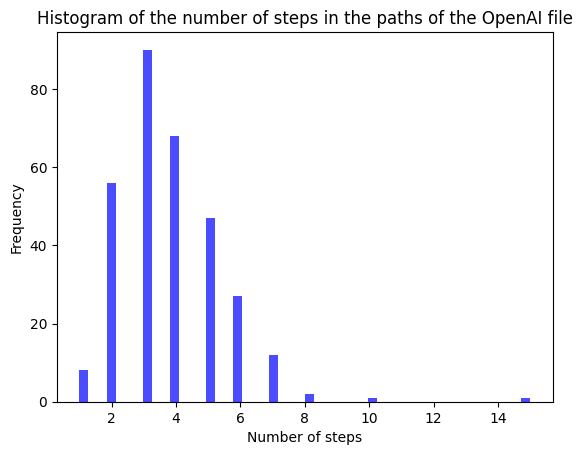

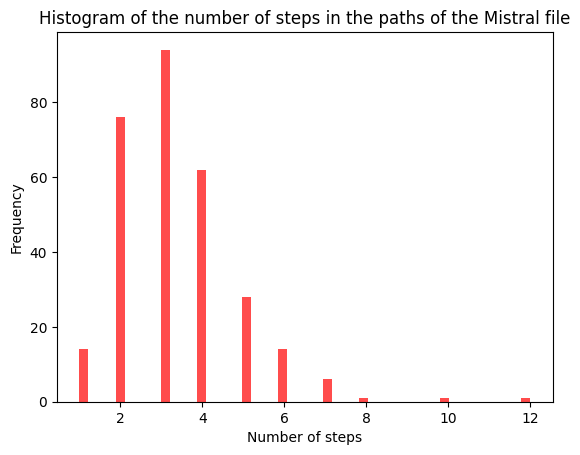

In [35]:
# we want to compare the number of steps in the paths of the openai and mistral files (column steps)


# plot the histogram of the number of steps in the paths of the openai file

plt.hist(df_openai_finished['steps'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Number of steps')
plt.ylabel('Frequency')
plt.title('Histogram of the number of steps in the paths of the OpenAI file')
plt.show()

# plot the histogram of the number of steps in the paths of the mistral file
plt.hist(df_mistral_finished['steps'], bins=50, color='red', alpha=0.7)
plt.xlabel('Number of steps')
plt.ylabel('Frequency')
plt.title('Histogram of the number of steps in the paths of the Mistral file')
plt.show() 

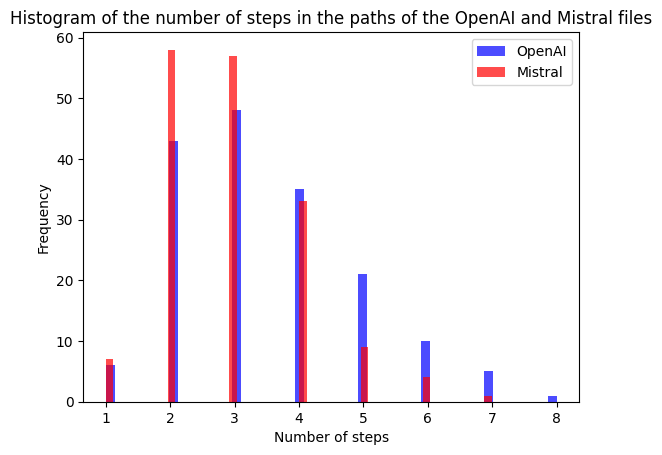

In [ ]:
# compare the 2 graphs above
plt.hist(df_openai_finished['steps'], bins=50, color='blue', alpha=0.7, label='OpenAI')
plt.hist(df_mistral_finished['steps'], bins=50, color='red', alpha=0.7, label='Mistral')
plt.xlabel('Number of steps')
plt.ylabel('Frequency')
plt.title('Histogram of the number of steps in the paths of the OpenAI and Mistral files')
plt.legend()
plt.show() 

In [36]:
# describe the steps column of the openai file
df_openai['steps'].describe()


count    565.000000
mean       2.095575
std        2.242734
min        0.000000
25%        0.000000
50%        2.000000
75%        4.000000
max       15.000000
Name: steps, dtype: float64

In [37]:
# describe the steps column of the mistral file
df_mistral['steps'].describe()

count    565.000000
mean       1.755752
std        1.984110
min        0.000000
25%        0.000000
50%        2.000000
75%        3.000000
max       12.000000
Name: steps, dtype: float64

In [38]:
import urllib.parse
# load categories.tsv file
# Load the TSV file
file_path = "data/wikispeedia_paths-and-graph/categories.tsv"
categories = pd.read_csv(file_path, sep='\t', skiprows=12, names=['article', 'category'])
categories = categories.map(urllib.parse.unquote)


In [39]:

articles_openai = df_openai['path'].apply(lambda x: x.split(';')).tolist()



articles_openai = [item for sublist in articles_openai for item in sublist]

# get the cartegoies of the articles
categories_of_articles_openai = []
for article in articles_openai:
    try:
        categories_of_articles_openai.append(categories[categories['article'] == article]['category'])
    except:
        pass

# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_openai = [item for sublist in categories_of_articles_openai for item in sublist]
categories_count_openai = pd.Series(categories_of_articles_openai).value_counts()

# print the 5 most common categories
print(categories_count_openai.head())
nbr_o = categories_count_openai.quantile(0.70)

subject.Countries                                          369
subject.History.General_history                            204
subject.Geography.European_Geography.European_Countries    138
subject.Citizenship.Politics_and_government                125
subject.Geography.North_American_Geography                 106
Name: count, dtype: int64


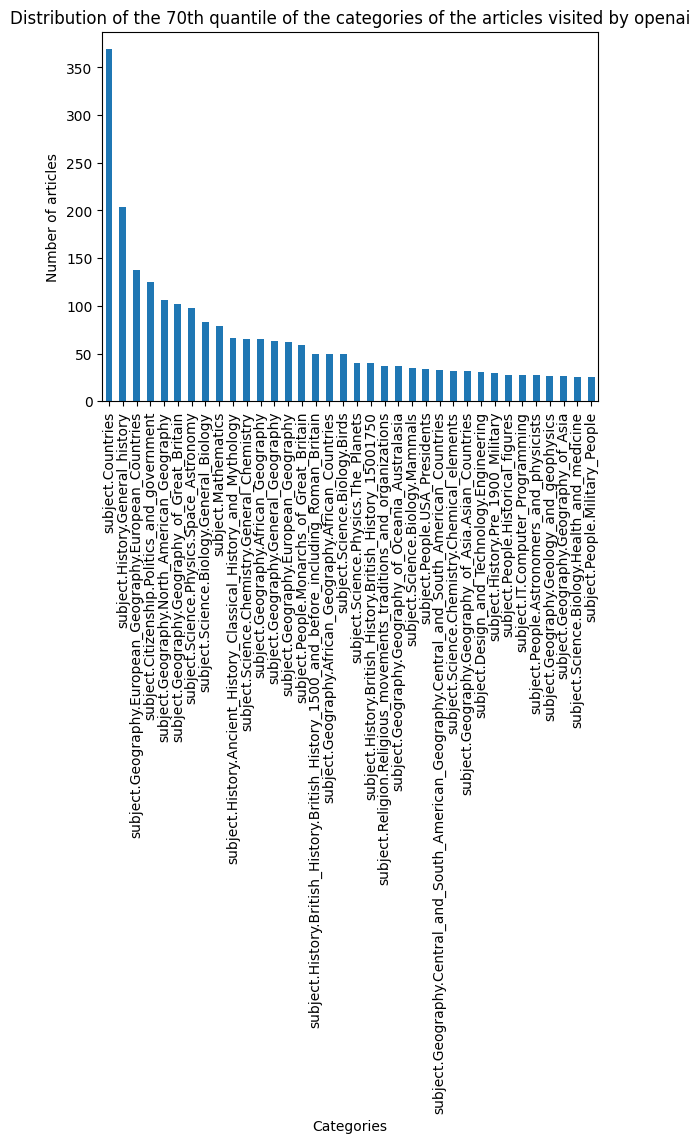

In [ ]:
# plot the distribution of the 70th quantile
categories_count_openai[categories_count_openai > nbr_o].plot(kind='bar')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by openai')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.show()

In [ ]:

articles_mistral = df_mistral['path'].apply(lambda x: x.split(';')).tolist()



articles_mistral = [item for sublist in articles_mistral for item in sublist]

# get the cartegoies of the articles
categories_of_articles_mistral = []
for article in articles_mistral:
    try:
        categories_of_articles_mistral.append(categories[categories['article'] == article]['category'])
    except:
        pass

# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_mistral = [item for sublist in categories_of_articles_mistral for item in sublist]
categories_count_mistral = pd.Series(categories_of_articles_mistral).value_counts()

# print the 5 most common categories
print(categories_count_mistral.head())
nbr_m = categories_count_mistral.quantile(0.70)

subject.Countries                                          290
subject.Geography.European_Geography.European_Countries    119
subject.Geography.North_American_Geography                 100
subject.Geography.Geography_of_Great_Britain                99
subject.History.General_history                             89
Name: count, dtype: int64


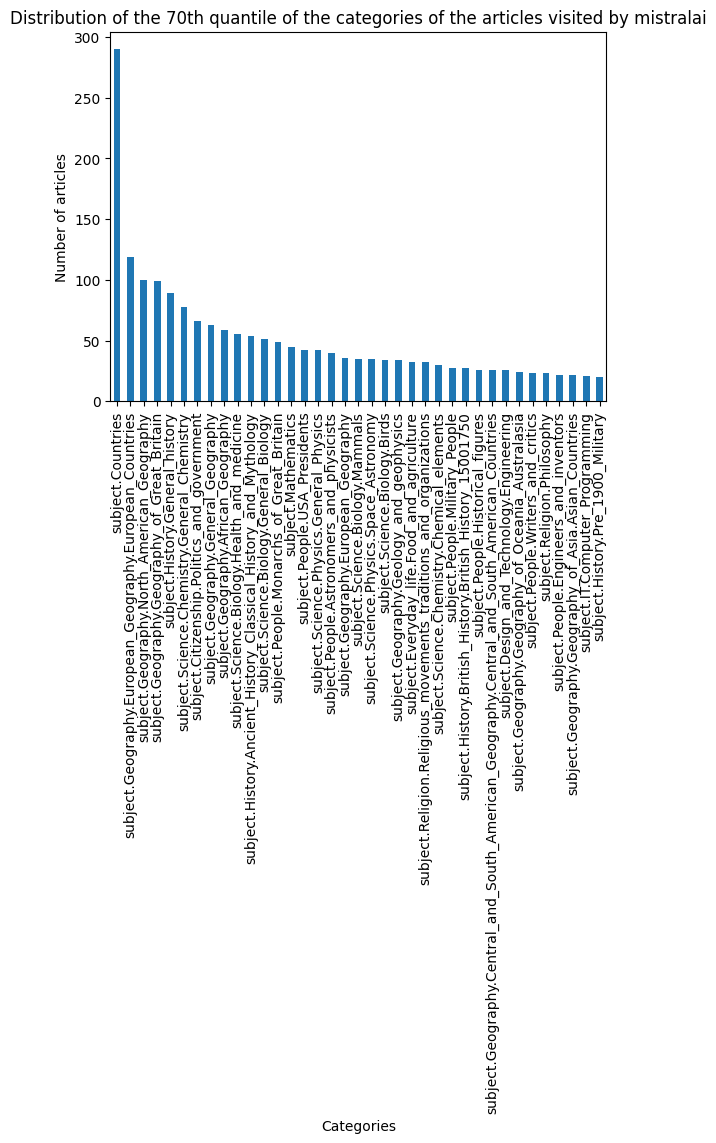

In [ ]:
# plot the distribution of the 70th quantile
categories_count_mistral[categories_count_mistral > nbr_m].plot(kind='bar')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by mistralai')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.show()

The number of unique articles human  765


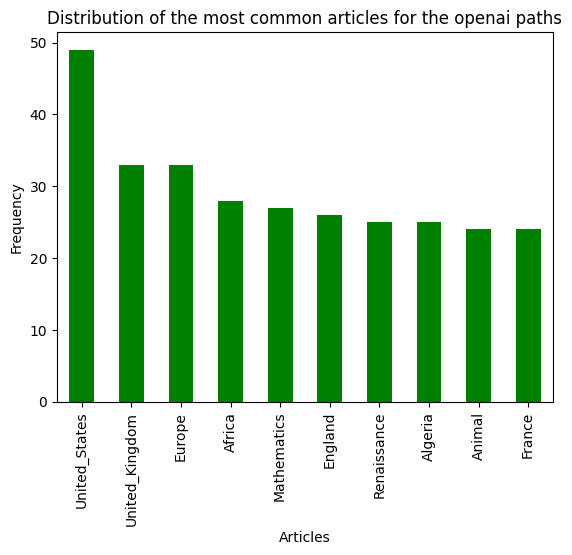

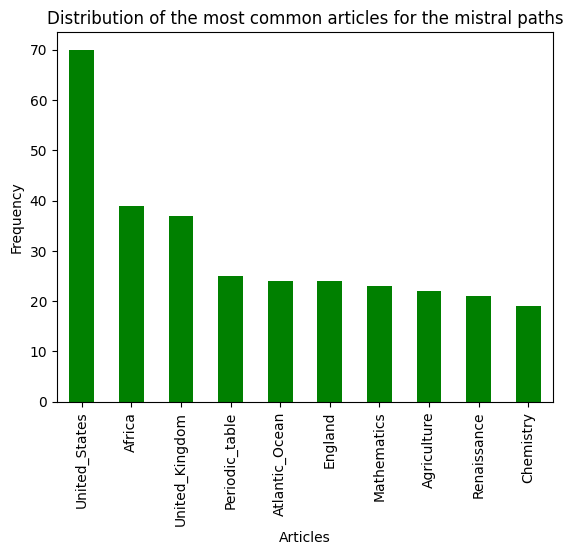

In [ ]:

# drop the loop_detected and wrong_answer articles
articles_openai = [article for article in articles_openai if article not in ['LOOP_DETECTED', 'WRONG_ANSWER']]


# Plot the distribution of the most common articles
articles_count_openai = pd.Series(articles_openai)
articles_count_openai = articles_count_openai.value_counts()
articles_count_openai = articles_count_openai.sort_values(ascending=False)
articles_count_openai = articles_count_openai[:10]
articles_count_openai.plot(kind='bar', color='green')
plt.title('Distribution of the most common articles for the openai paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()


# drop the loop_detected and wrong_answer articles
articles_mistral = [article for article in articles_mistral if article not in ['LOOP_DETECTED', 'WRONG_ANSWER']]



# Plot the distribution of the most common articles
articles_count_mistral = pd.Series(articles_mistral)
articles_count_mistral = articles_count_mistral.value_counts()
articles_count_mistral = articles_count_mistral.sort_values(ascending=False)
articles_count_mistral = articles_count_mistral[:10]
articles_count_mistral.plot(kind='bar', color='green')
plt.title('Distribution of the most common articles for the mistral paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()

